# Python logging - Users of python in different environments 

This notebook shows which users are using python in which environment.

 - [Number of unique users and total python invocations by environment / python executable (listing)](#uniq_users_by_env_)
 - [Number of unique users by environment / python executable (PLOT)](#uniq_users_by_env_plots)
 - [Total invocations by environment / python executable (PLOT)](#tot_invocations_by_env_plots)
 - [Users by environment / python executable (shortcuts to listings)](#shortcuts_to_env_listings)
 
### Notable directories:
 - **/project/avd/python/usage_logs** - Contains all logging from the SSS
 - **/project/avd/python/usage_logs/env_users** - Contains a file per SSS environment with a list of users inside. Can be used to compose an email to all users if needed.


## Setup

Let's get together all the imports that we'll need.

In [1]:
%matplotlib inline

import glob
import os
import heapq
import re
import pandas as pd
import datetime
from IPython.display import display, Markdown, Latex
import urllib.request
import json 
import ssl

Let's define some constants 1) set the time window in question, and 2) the environments URL endpoint

In [82]:
last_n_days = 90
envs_endpoint = "https://www-avd/sci/software_stack/_static/environments.json"

Let's retrieve our Scientifc Software Stack currently deployed environments from the envs endpoints:

In [83]:
def get_envs_from_endpoint():
    # Need unverified_context to avoid SSL issue
    unverified_context = ssl._create_unverified_context()

    with urllib.request.urlopen(envs_endpoint, context=unverified_context) as url:
        envs_response = json.loads(url.read().decode())
        return envs_response

In [84]:
envs_response = get_envs_from_endpoint()

# The envs endpoint doesn't use the env tag as a unique identifier. Hence some envs may effectively be duplicates. 
# We de-dupe by creating a dict keyed on env tag. Multiple labels may point to the same tag so we sort that too.
envs = {}
for env in envs_response: 
    tag = env['env_tag'][4:]
    label = env['label']
    if tag in envs:
        envs[tag]['labels'].append(label)
    else:
        envs[tag] = {'tag':tag, 'labels': [label]}

Let's just render the envs dict for a quick look at the currently deployed SSS envs:

In [85]:
envs

{'default-2019_02_27': {'tag': 'default-2019_02_27',
  'labels': ['next', 'current']},
 'default-2018_05_22-1': {'tag': 'default-2018_05_22-1',
  'labels': ['previous']},
 'default_legacy-2019_02_27': {'tag': 'default_legacy-2019_02_27',
  'labels': ['current']},
 'default_legacy-2018_05_22-1': {'tag': 'default_legacy-2018_05_22-1',
  'labels': ['previous']},
 'experimental-2020_03_10': {'tag': 'experimental-2020_03_10',
  'labels': ['current']},
 'preproduction-2020_03_03': {'tag': 'preproduction-2020_03_03',
  'labels': ['os44']},
 'production-2018_02_01': {'tag': 'production-2018_02_01',
  'labels': ['os41-1']},
 'production-2019_01_08': {'tag': 'production-2019_01_08',
  'labels': ['os42-1']},
 'production-2019_06_12': {'tag': 'production-2019_06_12',
  'labels': ['os43-1']},
 'production-2019_07_26': {'tag': 'production-2019_07_26',
  'labels': ['os43-2']},
 'production_legacy-2018_10_17-1': {'tag': 'production_legacy-2018_10_17-1',
  'labels': ['os42-1']},
 'production_legacy-201

### Load data
Let's define a function to get a list of the most recent daily log files. They have the format YYYYMMDD.txt. Ensure they are returned in order oldest to newest:

In [86]:
def get_last_n_days_of_log_files(n):
    wildcarded_filename = '20[12][90][01][0123456789][0123][0123456789].txt'
    list_of_files = glob.glob('/project/avd/python/usage_logs/' + wildcarded_filename) 
    latest_n_files = heapq.nlargest(n, list_of_files, key=os.path.getctime)
    latest_n_files.reverse()
    return latest_n_files

Now call the function get the latest log files:

In [87]:
latest_log_files = get_last_n_days_of_log_files(last_n_days)

Sanity check that they look correct:

In [88]:
latest_log_files

['/project/avd/python/usage_logs/20200303.txt',
 '/project/avd/python/usage_logs/20200304.txt',
 '/project/avd/python/usage_logs/20200305.txt',
 '/project/avd/python/usage_logs/20200306.txt',
 '/project/avd/python/usage_logs/20200307.txt',
 '/project/avd/python/usage_logs/20200308.txt',
 '/project/avd/python/usage_logs/20200211.txt',
 '/project/avd/python/usage_logs/20200229.txt',
 '/project/avd/python/usage_logs/20200207.txt',
 '/project/avd/python/usage_logs/20200206.txt',
 '/project/avd/python/usage_logs/20200228.txt',
 '/project/avd/python/usage_logs/20200309.txt',
 '/project/avd/python/usage_logs/20200310.txt',
 '/project/avd/python/usage_logs/20200312.txt',
 '/project/avd/python/usage_logs/20200313.txt',
 '/project/avd/python/usage_logs/20200314.txt',
 '/project/avd/python/usage_logs/20200315.txt',
 '/project/avd/python/usage_logs/20200316.txt',
 '/project/avd/python/usage_logs/20200319.txt',
 '/project/avd/python/usage_logs/20200321.txt',
 '/project/avd/python/usage_logs/2020032

### Data processing
Let's define a function to take a list of log files and return a dictionary of environments. The dictionary contains sub-dictionaries of each environment keyed by the path to the python executable. The sub-dictionary in turn contains a dictionary of usernames against number of python invocations by that user in that environment.

In [89]:
def get_env_user_counts(latest_log_files):
    
    env_dicts = {}
    
    def add_or_incr_env_and_user(env_path, user):
        if env_path in env_dicts.keys(): 
            # we've seen this env path before. Have we seen this user in this env?
            env = env_dicts[env_path]
            user_counts = env['user_counts']
            if user in user_counts.keys():
                # We've seen this env-user combo before. Increment the count
                user_counts[user] += 1
            else:
                # New user for this env. Add them
                user_counts[user] = 1   
        else:
            # we've not seen this env path before
            new_env = {
                'path': env_path,
                'user_counts': {}
            }
            new_env['user_counts'][user] = 1
            env_dicts[env_path] = new_env
        
    for fname in latest_log_files:
        with open(fname) as infile:
            for line in infile:
                if re.search(" startup ", line):
                    words = line.split()
                    user = words[3]
                    env_path = words[6]
                    add_or_incr_env_and_user(env_path, user)
    
    return env_dicts                

Call the function to get the environment dictionary from the log files (this takes a few minutes):

In [90]:
env_user_counts_dict = get_env_user_counts(latest_log_files)

Define another function. This one takes one of the above environment dictionaries and returns a pandas dataframe with columns of environment (python path), username, and number of python invocations.

In [91]:
def get_dataframe_from_dict(envs_dict):
    # Easiest way to get the dataframe is go via the construction of a list of dictionaries
    df_dicts = []

    for env in envs_dict.values():
        user_counts = env['user_counts']
        for user, count in user_counts.items():
            df_dict = {'env':env['path'], 'user':user, 'count':count}
            df_dicts.append(df_dict)
            pass

    return pd.DataFrame(df_dicts)

Now we call the above function to get our dataframe:

In [92]:
env_user_counts_df = get_dataframe_from_dict(env_user_counts_dict)

### Matching python executable paths with Scientific Software Stacks
We now loop through each row in our dataframe and try to match the python paths with known deployed scientific software stack environments defined at the top of the notebook. 

When matches are found the python path is overwritten by the environment tag. 

We also search for environments that aren't deployed currently but look like previously deployed environments with a similar path including datestring

The result is that the 'env' column in our dataframe now contains environment tags for all deployed (and readily guess-able previously deployed) environments. It still contains python paths for other python invocations that can't be readily tied to a Scientific Software Stack

In [93]:
for index, row in env_user_counts_df.iterrows():
    env_path = row['env']
    found_env = False
    
    for env in envs.values():
        env_tag = env['tag']
        env_labels = env['labels']
        env_type = env_tag.split("-")[0]
        env_date = env_tag.split("-")[1]
        grep_terms = [env_type + "/" + env_date]
        for label in env_labels:
            grep_terms.append(env_type + "/" + label)
            
        for grep_term in grep_terms:
            if grep_term in env_path:
                found_env = True
                env_user_counts_df.at[index, 'env'] = env['tag']
                break
        
        other_dates = re.findall('20[01][\d]_[01][\d]_[0123][\d]', env_path)
        other_grep_terms = []
        for other_date in other_dates:
            other_grep_terms.append(env_type + "/" + other_date)
        
        for other_grep_term in other_grep_terms:
            if other_grep_term in env_path:
                found_env = True
                env_user_counts_df.at[index, 'env'] = env_type + "-" + other_dates[0]
                break
            
        if found_env == True:
            break

Next we define a function which takes an enviornment tag and returns 'description tags' that are associated with it. For example the tag 'default-2019_02_27' at the time of writing is associated with the two description tags of 'default-current' and 'default-next':

In [94]:
def get_env_desc_labels(tag):
    env = envs.get(tag)
    desc_tags = []
    desc_tags_str = ''
    
    if env is not None:
        for label in env['labels']:
            desc_tags.append(env['tag'].split("-")[0] + "-" + label)
            desc_tags_str = '[' + ', '.join(desc_tags) + ']'
        
    return desc_tags_str

### Calculate the number of unique users per environment, and the total python invocations per environment:
When we have these two metrics by environment we merge together into a single 'envs_summary' pandas dataframe

In [95]:
tot_invocations = env_user_counts_df.groupby('env').sum()
n_uniq_users = env_user_counts_df.groupby('env')['user'].nunique()

envs_summary = pd.merge(tot_invocations, n_uniq_users, on='env')
envs_summary.sort_values(by='user', ascending=False, inplace=True)

### Display number of unique users and total python invocations per environment:
Display the above metrics per environment. For each environment we show its tag (which may revert to its python path if it's not recognised) and its decription-tag if it has one

First a few formatting parameters:

In [96]:
col_1_width = 10
col_2_width = 15
col_3_width = 50
rule_width = 145

Define a function for printing the table header:

In [97]:
def print_header():
    print('\n\nNumber of unique users of environments in the', last_n_days, 'days prior to', str(datetime.date.today()))
    print('=' * rule_width)
    print("{:>{width_1}} \t {:>{width_2}} \t {:<{width_3}} \t {}".format("Uniq users", "Tot Invocations", "Environment Description-Tag(s)", "Environment Tag or python executable", \
        width_1 = col_1_width, width_2 = col_2_width, width_3 = col_3_width))
    print('-' * rule_width)

Now we print the metrics, by calling the header printing function and then iterating over the env_summary dataframe rows:

<a id="uniq_users_by_env_"></a>

In [98]:
print_header()

for tag, row in envs_summary.iterrows():
    desc_tags = get_env_desc_labels(tag)
    filler = (col_3_width - len(desc_tags) - 1) * "-"
    col_2_content = desc_tags + " " + filler
    print("{:>{width_1}} \t {:>{width_2}} \t {:<{width_3}} \t {}".format(row['user'], row['count'], col_2_content, tag, width_1 = col_1_width, width_2 = col_2_width, width_3 = col_3_width))



Number of unique users of environments in the 90 days prior to 2020-05-27
Uniq users 	 Tot Invocations 	 Environment Description-Tag(s)                     	 Environment Tag or python executable
-------------------------------------------------------------------------------------------------------------------------------------------------
       577 	        18822425 	 [default-next, default-current] ------------------ 	 default-2019_02_27
       306 	          338094 	 [default_legacy-current] ------------------------- 	 default_legacy-2019_02_27
       261 	         4153382 	 [experimental-current] --------------------------- 	 experimental-2020_03_10
       158 	         5599919 	 [production-os42-1] ------------------------------ 	 production-2019_01_08
       150 	           22398 	 [default-previous] ------------------------------- 	 default-2018_05_22-1
       146 	         2052171 	 [production-os41-1] ------------------------------ 	 production-2018_02_01
       144 	       

# Plotting

Set a limit for how many bars are plotting on any one bar graph (to stop them squashing together with illegible labels):

In [100]:
n_bars_limit = 50

## Plots of number of unique users by environment

First plot with linear scale, second with a log scale

<a id="uniq_users_by_env_plots"></a>

Text(0,0.5,'Number of unique users over 90 days (log scale)')

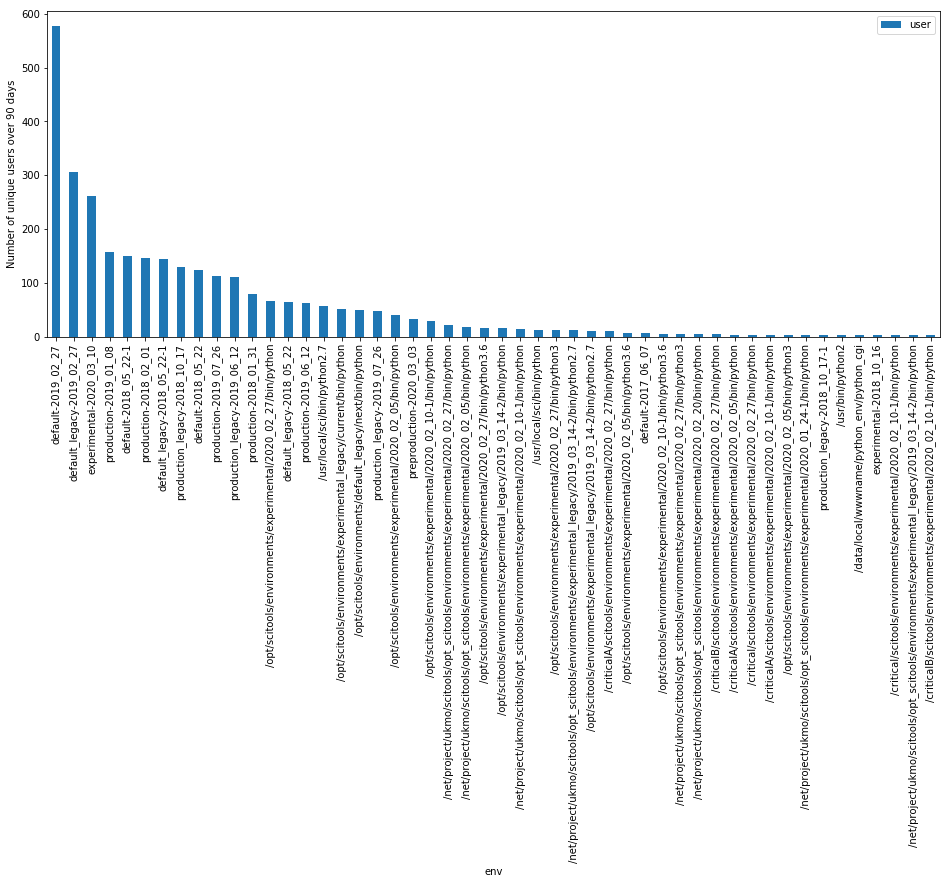

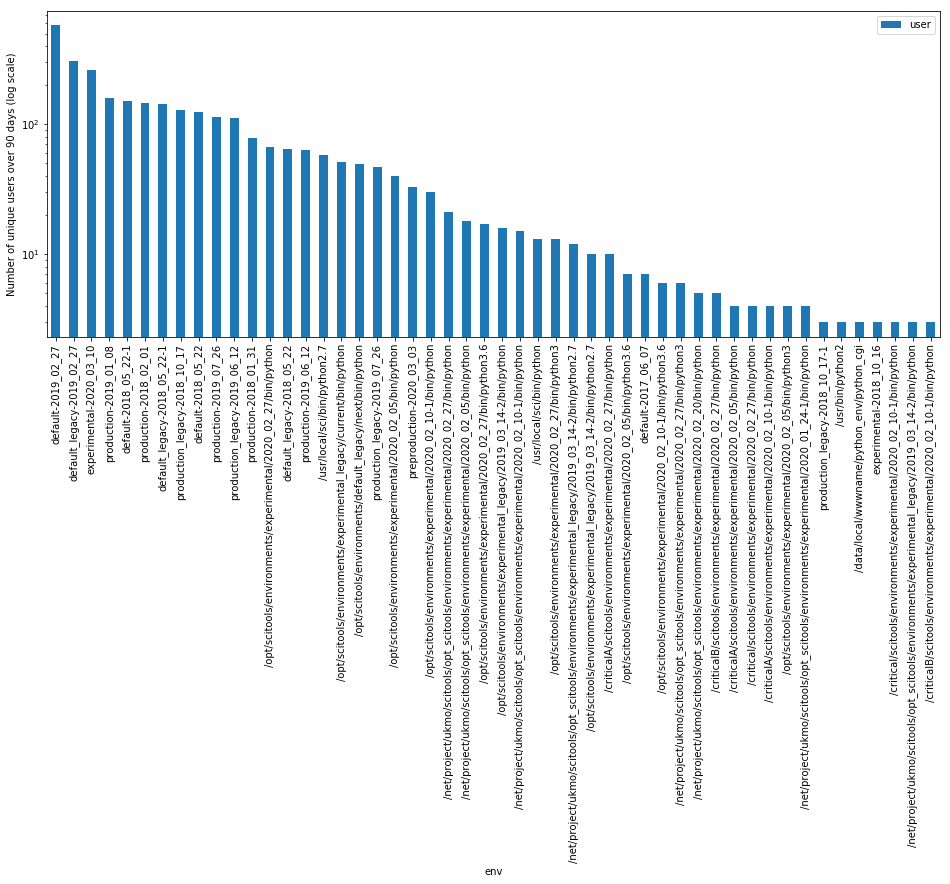

In [101]:
envs_summary.sort_values(by='user', ascending=False, inplace=True)

ax1 = envs_summary.head(n_bars_limit).plot.bar(y="user", logy=False, figsize=(16,6))
ax1.set_ylabel("Number of unique users over " + str(last_n_days) + " days")

ax2 = envs_summary.head(n_bars_limit).plot.bar(y="user", logy=True, figsize=(16,6))
ax2.set_ylabel("Number of unique users over " + str(last_n_days) + " days (log scale)")

## Plots of total number of python invocations by environment

First with a linear scale, then with a log scale

<a id="tot_invocations_by_env_plots"></a>

Text(0,0.5,'Total Python invocations over 90 days (log scale)')

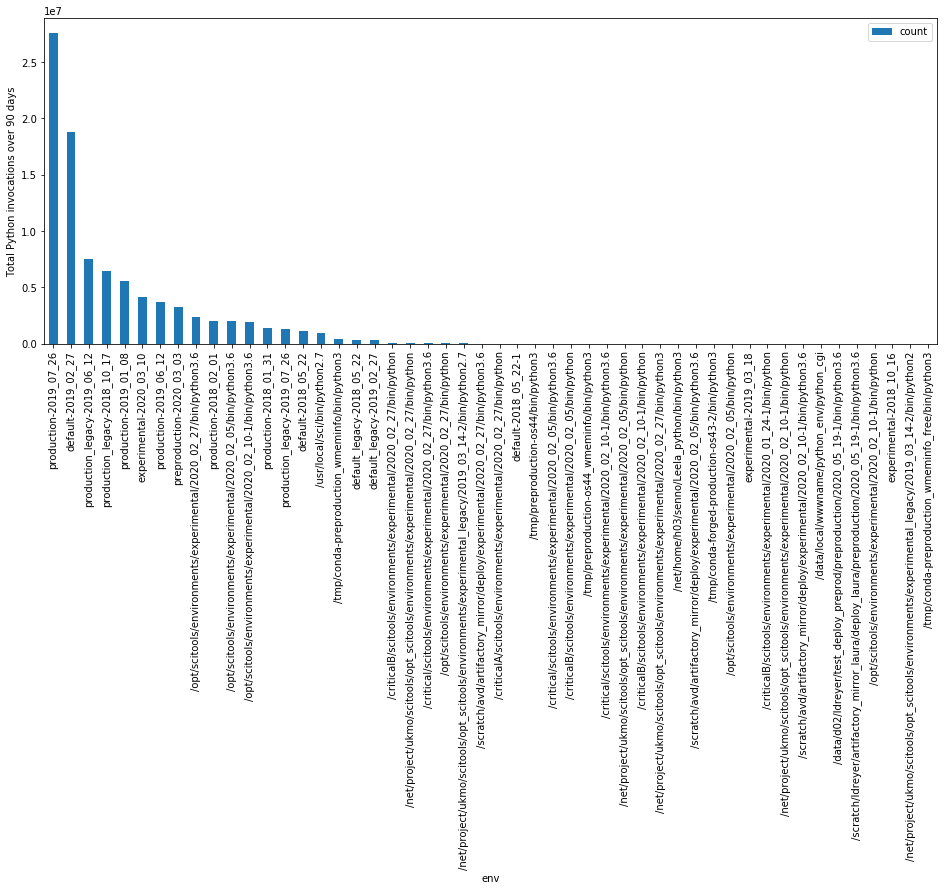

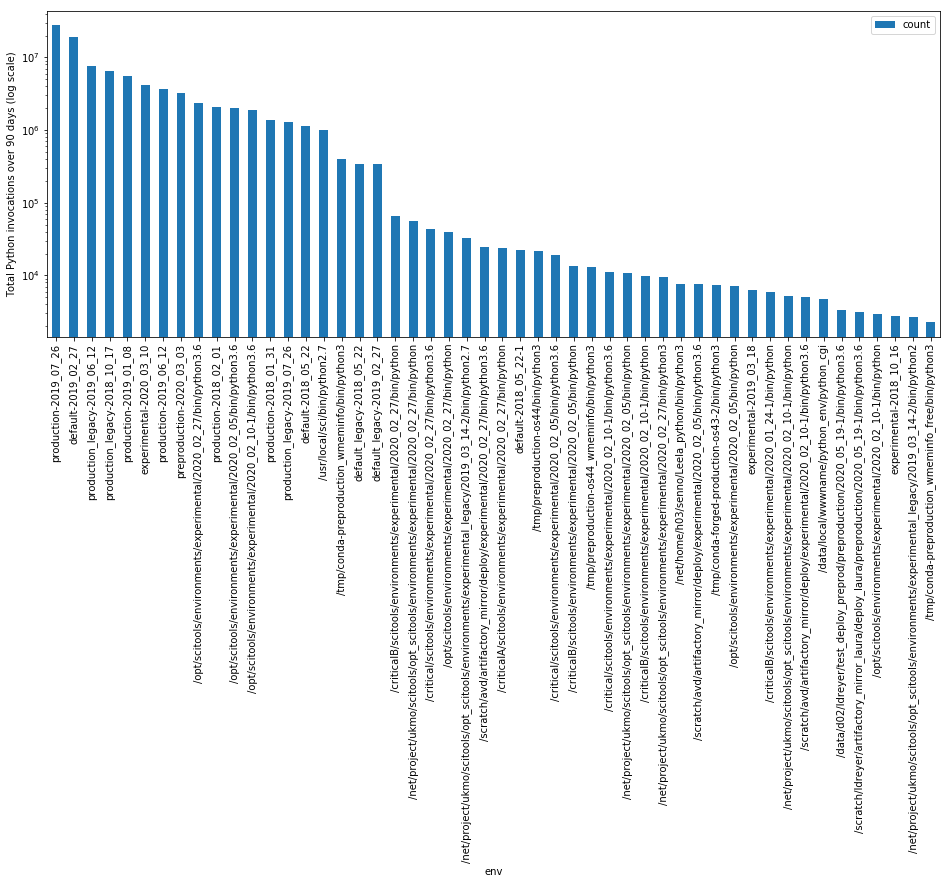

In [102]:
envs_summary.sort_values(by='count', ascending=False, inplace=True)

ax1 = envs_summary.head(n_bars_limit).plot.bar(y="count", logy=False, figsize=(16,6))
ax1.set_ylabel("Total Python invocations over " + str(last_n_days) + " days")

ax2 = envs_summary.head(n_bars_limit).plot.bar(y="count", logy=True, figsize=(16,6))
ax2.set_ylabel("Total Python invocations over " + str(last_n_days) + " days (log scale)")

### Prepare number of invocations per user per environment:

We create an array to hold all enviornments (each of the ones with a separate entry in the above plots and listing). For each of these we create a dictionary with its tag and a pandas dataframe holding it's user invocation counts

In [103]:
all_envs = []

envs_summary.sort_values(by='user', ascending=False, inplace=True)
for tag, row in envs_summary.iterrows():
    
    env = {'tag': tag, 'n_uniq': row['user'], 'tot_invocations': row['count']}
    
    env['df'] = env_user_counts_df \
        .loc[env_user_counts_df['env'] == tag] \
        .groupby('user', as_index=False) \
        .sum() \
        .sort_values(by=['count'], ascending=False, inplace=False)
    
    all_envs.append(env)

## Write to file all the users of each environment

As well as displaying the users of each environment in tabular form below, we also want to write a file of email addresses of users per environment for easy usage with mailing if required (e.g. to notify users of an environment about to be retired)

To do this we define a couple of functions. First to get all the users, and second to write them to file:

In [104]:
directory = "/project/avd/python/usage_logs/env_users"
display(Markdown('### Files of user emails per environment will be written to:'))
display(Markdown('### **' + directory + '**'))

### Files of user emails per environment will be written to:

### **/project/avd/python/usage_logs/env_users**

In [105]:
def get_all_users_of_env(env):
    dataframe = env['df']
    
    all_emails = []
    
    for index, row in dataframe.iterrows():
        alias_grep_term = "'" + row['user'] + " :'"
        user_email = !grep $alias_grep_term /etc/aliases | cut -d":" -f2 | sed "s/ //"
        
        # if alias_grep_term isn't present in /etc/aliases we know the relevant email address is just 
        # created by adding '@metoffice.gov.uk' to the username (as advised by Mark Crossland May 2020)
        if not user_email:
            user_email = [row['user'] + "@metoffice.gov.uk"]
        
        all_emails = all_emails + user_email
            
    return all_emails

In [106]:
def write_users_of_env_to_file(env):
    
    emails = get_all_users_of_env(env)
    
    user_emails = "[NONE]" if len(emails) == 0 else ";".join(emails)
    mod_tag = env['tag'].replace("/", ".")
    mod_tag = mod_tag[0].replace(".","") + mod_tag[1:]
    
    # Users with emails
    emails_filename = (directory + "/" + mod_tag + ".txt")
    if len(emails_filename) < 256:
        with open(emails_filename, 'w') as outfile:
            outfile.write(user_emails)

Now we loop over all the environments and call our function to write users of each one to file

In [ ]:
for env in all_envs:
    write_users_of_env_to_file(env)

## Display the listings of user invocations of Python per environment.
First, some parameters for formatting output:

In [107]:
col_1_width = 13
col_2_width = 10
rule_width = 120
header_width = 40

Next define a function for printing a table header:

In [108]:
def print_env_header(env, top_n):
    
    tag = env['tag']
    labels = get_env_desc_labels(tag)
    n_uniq = env['n_uniq']
    qualifier = "Top" if top_n < 9999 else "All"
        
    print('=' * rule_width)
    print("{:<{width}} \t {}".format("Environment TAG (or python executable):", tag, width = header_width))
    print("{:<{width}} \t {}".format("Environment DESCRIPTION-TAG(S):", labels, width = header_width))
    print("{:<{width}} \t {}".format("Environment NUM. UNIQUE USERS:", n_uniq, width = header_width))
    print('=' * rule_width)
    print('\n' + qualifier, 'users of the environment in the', last_n_days, 'days prior to', str(datetime.date.today()))
    print('-' * rule_width)
    print("{:>{width_1}} \t {:<{width_2}} \t [Email]".format("N.Invocations", "User", width_1 = col_1_width, width_2 = col_2_width))
    print('-' * rule_width)

Next we define the display function that takes an element of the all_envs array and displays the top n (or all) users of python in this environment, along with their number of python invocations and their email address sourced from /etc/aliases

In [109]:
def print_env_users(env, top_n=9999): 
    
    print_env_header(env, top_n)

    dataframe = env['df']
    rows = dataframe.head(top_n)
    
    for index, row in rows.iterrows():
        alias_grep_term = "'" + row['user'] + " :'"
        user_email = !grep $alias_grep_term /etc/aliases | cut -d":" -f2 | sed "s/ //"
        
        # if alias_grep_term isn't present in /etc/aliases we know the relevant email address is just 
        # created by adding '@metoffice.gov.uk' to the username (as advised by Mark Crossland May 2020)
        if not user_email:
            user_email = [row['user'] + "@metoffice.gov.uk"]
            
        print("{:>{width_1}} \t {:<{width_2}} \t {}".format(row['count'], row['user'], user_email, width_1 = col_1_width, width_2 = col_2_width))

Finally, we loop over all environments again twice more. Firstly to print a shortcut link to the listing for each one, and secondly to print the actual listing itself

In [110]:
display(Markdown('<a id="shortcuts_to_env_listings"></a>'))
display(Markdown('## Shortcuts to listings of users per environment:'))
for env in all_envs:
    tag = env['tag']
    labels = get_env_desc_labels(tag)
    
    display(Markdown(' - [' + tag + '](#' + tag + ') ' + labels + ' - **' + str(env['n_uniq']) + '** unique users'))
    
for env in all_envs:
    tag = env['tag']
    labels = get_env_desc_labels(tag)
    
    print('\n')
    display(Markdown('<a id="' + tag + '"></a>'))
    display(Markdown('[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)'))
    print_env_users(env)
    print('\n')

<a id="shortcuts_to_env_listings"></a>

## Shortcuts to listings of users per environment:

 - [default-2019_02_27](#default-2019_02_27) [default-next, default-current] - **577** unique users

 - [default_legacy-2019_02_27](#default_legacy-2019_02_27) [default_legacy-current] - **306** unique users

 - [experimental-2020_03_10](#experimental-2020_03_10) [experimental-current] - **261** unique users

 - [production-2019_01_08](#production-2019_01_08) [production-os42-1] - **158** unique users

 - [default-2018_05_22-1](#default-2018_05_22-1) [default-previous] - **150** unique users

 - [production-2018_02_01](#production-2018_02_01) [production-os41-1] - **146** unique users

 - [default_legacy-2018_05_22-1](#default_legacy-2018_05_22-1) [default_legacy-previous] - **144** unique users

 - [production_legacy-2018_10_17](#production_legacy-2018_10_17)  - **129** unique users

 - [default-2018_05_22](#default-2018_05_22)  - **124** unique users

 - [production-2019_07_26](#production-2019_07_26) [production-os43-2] - **113** unique users

 - [production_legacy-2019_06_12](#production_legacy-2019_06_12) [production_legacy-os43-1] - **112** unique users

 - [production-2018_01_31](#production-2018_01_31)  - **79** unique users

 - [/opt/scitools/environments/experimental/2020_02_27/bin/python](#/opt/scitools/environments/experimental/2020_02_27/bin/python)  - **67** unique users

 - [default_legacy-2018_05_22](#default_legacy-2018_05_22)  - **65** unique users

 - [production-2019_06_12](#production-2019_06_12) [production-os43-1] - **63** unique users

 - [/usr/local/sci/bin/python2.7](#/usr/local/sci/bin/python2.7)  - **58** unique users

 - [/opt/scitools/environments/experimental_legacy/current/bin/python](#/opt/scitools/environments/experimental_legacy/current/bin/python)  - **51** unique users

 - [/opt/scitools/environments/default_legacy/next/bin/python](#/opt/scitools/environments/default_legacy/next/bin/python)  - **49** unique users

 - [production_legacy-2019_07_26](#production_legacy-2019_07_26) [production_legacy-os43-2] - **47** unique users

 - [/opt/scitools/environments/experimental/2020_02_05/bin/python](#/opt/scitools/environments/experimental/2020_02_05/bin/python)  - **40** unique users

 - [preproduction-2020_03_03](#preproduction-2020_03_03) [preproduction-os44] - **33** unique users

 - [/opt/scitools/environments/experimental/2020_02_10-1/bin/python](#/opt/scitools/environments/experimental/2020_02_10-1/bin/python)  - **30** unique users

 - [/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_27/bin/python](#/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_27/bin/python)  - **21** unique users

 - [/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_05/bin/python](#/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_05/bin/python)  - **18** unique users

 - [/opt/scitools/environments/experimental/2020_02_27/bin/python3.6](#/opt/scitools/environments/experimental/2020_02_27/bin/python3.6)  - **17** unique users

 - [/opt/scitools/environments/experimental_legacy/2019_03_14-2/bin/python](#/opt/scitools/environments/experimental_legacy/2019_03_14-2/bin/python)  - **16** unique users

 - [/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_10-1/bin/python](#/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_10-1/bin/python)  - **15** unique users

 - [/opt/scitools/environments/experimental/2020_02_27/bin/python3](#/opt/scitools/environments/experimental/2020_02_27/bin/python3)  - **13** unique users

 - [/usr/local/sci/bin/python](#/usr/local/sci/bin/python)  - **13** unique users

 - [/net/project/ukmo/scitools/opt_scitools/environments/experimental_legacy/2019_03_14-2/bin/python2.7](#/net/project/ukmo/scitools/opt_scitools/environments/experimental_legacy/2019_03_14-2/bin/python2.7)  - **12** unique users

 - [/opt/scitools/environments/experimental_legacy/2019_03_14-2/bin/python2.7](#/opt/scitools/environments/experimental_legacy/2019_03_14-2/bin/python2.7)  - **10** unique users

 - [/criticalA/scitools/environments/experimental/2020_02_27/bin/python](#/criticalA/scitools/environments/experimental/2020_02_27/bin/python)  - **10** unique users

 - [default-2017_06_07](#default-2017_06_07)  - **7** unique users

 - [/opt/scitools/environments/experimental/2020_02_05/bin/python3.6](#/opt/scitools/environments/experimental/2020_02_05/bin/python3.6)  - **7** unique users

 - [/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_27/bin/python3](#/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_27/bin/python3)  - **6** unique users

 - [/opt/scitools/environments/experimental/2020_02_10-1/bin/python3.6](#/opt/scitools/environments/experimental/2020_02_10-1/bin/python3.6)  - **6** unique users

 - [/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_20/bin/python](#/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_20/bin/python)  - **5** unique users

 - [/criticalB/scitools/environments/experimental/2020_02_27/bin/python](#/criticalB/scitools/environments/experimental/2020_02_27/bin/python)  - **5** unique users

 - [/opt/scitools/environments/experimental/2020_02_05/bin/python3](#/opt/scitools/environments/experimental/2020_02_05/bin/python3)  - **4** unique users

 - [/critical/scitools/environments/experimental/2020_02_27/bin/python](#/critical/scitools/environments/experimental/2020_02_27/bin/python)  - **4** unique users

 - [/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_01_24-1/bin/python](#/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_01_24-1/bin/python)  - **4** unique users

 - [/criticalA/scitools/environments/experimental/2020_02_10-1/bin/python](#/criticalA/scitools/environments/experimental/2020_02_10-1/bin/python)  - **4** unique users

 - [/criticalA/scitools/environments/experimental/2020_02_05/bin/python](#/criticalA/scitools/environments/experimental/2020_02_05/bin/python)  - **4** unique users

 - [/project/avd/sss/temp_envs/miniconda3/envs/production_legacy-os42-1/bin/python](#/project/avd/sss/temp_envs/miniconda3/envs/production_legacy-os42-1/bin/python)  - **3** unique users

 - [/net/project/ukmo/scitools/opt_scitools/environments/experimental_legacy/2019_03_14-2/bin/python](#/net/project/ukmo/scitools/opt_scitools/environments/experimental_legacy/2019_03_14-2/bin/python)  - **3** unique users

 - [experimental-2018_10_16](#experimental-2018_10_16)  - **3** unique users

 - [/criticalB/scitools/environments/experimental/2020_02_10-1/bin/python](#/criticalB/scitools/environments/experimental/2020_02_10-1/bin/python)  - **3** unique users

 - [/opt/scitools/environments/experimental/2020_02_20/bin/python](#/opt/scitools/environments/experimental/2020_02_20/bin/python)  - **3** unique users

 - [/usr/bin/python2](#/usr/bin/python2)  - **3** unique users

 - [/critical/scitools/environments/experimental/2020_02_10-1/bin/python](#/critical/scitools/environments/experimental/2020_02_10-1/bin/python)  - **3** unique users

 - [/data/local/wwwname/python_env/python_cgi](#/data/local/wwwname/python_env/python_cgi)  - **3** unique users

 - [/opt/scitools/environments/experimental/2020_01_24-1/bin/python](#/opt/scitools/environments/experimental/2020_01_24-1/bin/python)  - **3** unique users

 - [production_legacy-2018_10_17-1](#production_legacy-2018_10_17-1) [production_legacy-os42-1] - **3** unique users

 - [/usr/bin/python](#/usr/bin/python)  - **2** unique users

 - [/criticalA/scitools/environments/experimental/2020_02_10-1/bin/python3.6](#/criticalA/scitools/environments/experimental/2020_02_10-1/bin/python3.6)  - **2** unique users

 - [/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_10-1/bin/python3](#/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_10-1/bin/python3)  - **2** unique users

 - [/criticalB/scitools/environments/experimental_legacy/2019_03_14-2/bin/python](#/criticalB/scitools/environments/experimental_legacy/2019_03_14-2/bin/python)  - **2** unique users

 - [/common/scitools/environments/experimental_legacy/2019_03_14-2/bin/python](#/common/scitools/environments/experimental_legacy/2019_03_14-2/bin/python)  - **2** unique users

 - [experimental-2018_03_27](#experimental-2018_03_27)  - **2** unique users

 - [/criticalB/scitools/environments/experimental/2020_02_27/bin/python3.6](#/criticalB/scitools/environments/experimental/2020_02_27/bin/python3.6)  - **2** unique users

 - [/data/users/frfx/venv/microwave_for_smrt/bin/python](#/data/users/frfx/venv/microwave_for_smrt/bin/python)  - **2** unique users

 - [/common/scitools/environments/experimental_legacy/2019_03_14-2/bin/python2](#/common/scitools/environments/experimental_legacy/2019_03_14-2/bin/python2)  - **2** unique users

 - [/home/h01/rsmt/hermes/hermes-f874736f-6336-4214-a134-844d4a3b74e6/bin/python](#/home/h01/rsmt/hermes/hermes-f874736f-6336-4214-a134-844d4a3b74e6/bin/python)  - **2** unique users

 - [/opt/scitools/environments/experimental_legacy/current/bin/python2.7](#/opt/scitools/environments/experimental_legacy/current/bin/python2.7)  - **2** unique users

 - [/home/h01/bsherrat/envs/testytest/bin/python](#/home/h01/bsherrat/envs/testytest/bin/python)  - **2** unique users

 - [/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_05/bin/python3](#/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_05/bin/python3)  - **2** unique users

 - [/project/avd/sss/temp_envs/miniconda3/envs/default_legacy-2018_05_03/bin/python2.7](#/project/avd/sss/temp_envs/miniconda3/envs/default_legacy-2018_05_03/bin/python2.7)  - **2** unique users

 - [/net/project/ukmo/scitools/opt_scitools/environments/experimental_legacy/2019_03_14-2/bin/python2](#/net/project/ukmo/scitools/opt_scitools/environments/experimental_legacy/2019_03_14-2/bin/python2)  - **2** unique users

 - [/usr/bin/python3.6](#/usr/bin/python3.6)  - **2** unique users

 - [/criticalB/scitools/environments/experimental/2020_02_10-1/bin/python3.6](#/criticalB/scitools/environments/experimental/2020_02_10-1/bin/python3.6)  - **2** unique users

 - [experimental-2019_03_18](#experimental-2019_03_18)  - **2** unique users

 - [/data/users/dbentley/customenv/miniconda2/bin/python](#/data/users/dbentley/customenv/miniconda2/bin/python)  - **1** unique users

 - [/project/avd/sss/temp_envs/miniconda3/envs/default_legacy-2018_05_22-1/bin/python](#/project/avd/sss/temp_envs/miniconda3/envs/default_legacy-2018_05_22-1/bin/python)  - **1** unique users

 - [/home/h01/aowen/miniconda3/envs/production-os43-1/bin/python](#/home/h01/aowen/miniconda3/envs/production-os43-1/bin/python)  - **1** unique users

 - [/criticalA/scitools/environments/experimental/2020_02_27/bin/python3.6](#/criticalA/scitools/environments/experimental/2020_02_27/bin/python3.6)  - **1** unique users

 - [/data/users/hadpb/conda/environments/ctst/bin/python](#/data/users/hadpb/conda/environments/ctst/bin/python)  - **1** unique users

 - [/tmp/prod/bin/python](#/tmp/prod/bin/python)  - **1** unique users

 - [/data/users/frfx/venv/mw_test_venv/bin/python3](#/data/users/frfx/venv/mw_test_venv/bin/python3)  - **1** unique users

 - [experimental-2018_10_04](#experimental-2018_10_04)  - **1** unique users

 - [/data/d02/ldreyer/temp_deploy/environments/preproduction/2020_05_15/bin/python](#/data/d02/ldreyer/temp_deploy/environments/preproduction/2020_05_15/bin/python)  - **1** unique users

 - [/tmp/test_env/bin/python](#/tmp/test_env/bin/python)  - **1** unique users

 - [/opt/scitools/environments/experimental/2020_02_10-1/bin/python3](#/opt/scitools/environments/experimental/2020_02_10-1/bin/python3)  - **1** unique users

 - [/data/local/frpm/hermes/hermes-b34073f3-6812-42cc-80b8-2f80a00495d9/bin/python](#/data/local/frpm/hermes/hermes-b34073f3-6812-42cc-80b8-2f80a00495d9/bin/python)  - **1** unique users

 - [/data/local/frpm/hermes/hermes-f8da3bee-a916-4924-98dc-4949347051fc/bin/python](#/data/local/frpm/hermes/hermes-f8da3bee-a916-4924-98dc-4949347051fc/bin/python)  - **1** unique users

 - [/data/local/frpm/hermes/hermes-b185a4de-dd4c-46e6-9dc7-81d1f3755889/bin/python](#/data/local/frpm/hermes/hermes-b185a4de-dd4c-46e6-9dc7-81d1f3755889/bin/python)  - **1** unique users

 - [/project/SatImagery/utils/miniconda3/envs/sat_py36/bin/python](#/project/SatImagery/utils/miniconda3/envs/sat_py36/bin/python)  - **1** unique users

 - [/criticalB/scitools/environments/experimental/2020_02_05/bin/python3](#/criticalB/scitools/environments/experimental/2020_02_05/bin/python3)  - **1** unique users

 - [/data/users/frfx/clean_scitools_venv/bin/python3](#/data/users/frfx/clean_scitools_venv/bin/python3)  - **1** unique users

 - [/net/home/h02/ahorsema/Exp/VirtPy3ATDnet/bin/python](#/net/home/h02/ahorsema/Exp/VirtPy3ATDnet/bin/python)  - **1** unique users

 - [/data/local/frpm/hermes/hermes-68f0ac3b-939d-4483-b77e-3c0695e2ae33/bin/python](#/data/local/frpm/hermes/hermes-68f0ac3b-939d-4483-b77e-3c0695e2ae33/bin/python)  - **1** unique users

 - [/home/h01/aowen/miniconda3/envs/stage_test/bin/python](#/home/h01/aowen/miniconda3/envs/stage_test/bin/python)  - **1** unique users

 - [/home/conda_builder/conda-bld/mo_sitecustomize_1589806557110/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python](#/home/conda_builder/conda-bld/mo_sitecustomize_1589806557110/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python)  - **1** unique users

 - [/criticalA/scitools/environments/experimental/2020_01_24-1/bin/python](#/criticalA/scitools/environments/experimental/2020_01_24-1/bin/python)  - **1** unique users

 - [/data/local/frpm/hermes/hermes-423ad8bf-7d2e-4bac-8e74-01f0b96edf30/bin/python](#/data/local/frpm/hermes/hermes-423ad8bf-7d2e-4bac-8e74-01f0b96edf30/bin/python)  - **1** unique users

 - [/home/conda_builder/conda-bld/mo_sitecustomize_1589816443793/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python](#/home/conda_builder/conda-bld/mo_sitecustomize_1589816443793/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python)  - **1** unique users

 - [/tmp/conda_building/production-os43-1/bin/python](#/tmp/conda_building/production-os43-1/bin/python)  - **1** unique users

 - [/data/local/frpm/hermes/hermes-1cd2acee-02cd-471c-93ed-ac685dbdd23f/bin/python](#/data/local/frpm/hermes/hermes-1cd2acee-02cd-471c-93ed-ac685dbdd23f/bin/python)  - **1** unique users

 - [/home/conda_builder/conda-bld/mo_sitecustomize_1589744681657/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python](#/home/conda_builder/conda-bld/mo_sitecustomize_1589744681657/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python)  - **1** unique users

 - [/data/local/frpm/hermes/hermes-3b64ae36-5198-4a81-a9bf-4d7a140b83f7/bin/python](#/data/local/frpm/hermes/hermes-3b64ae36-5198-4a81-a9bf-4d7a140b83f7/bin/python)  - **1** unique users

 - [/data/local/frpm/hermes/hermes-ba294d81-4443-4128-a1c5-3e5e2dad443b/bin/python](#/data/local/frpm/hermes/hermes-ba294d81-4443-4128-a1c5-3e5e2dad443b/bin/python)  - **1** unique users

 - [/home/conda_builder/conda-bld/mo_sitecustomize_1589523510349/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python](#/home/conda_builder/conda-bld/mo_sitecustomize_1589523510349/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python)  - **1** unique users

 - [/hpc/home/d05/lbeard/tmp/bin/python](#/hpc/home/d05/lbeard/tmp/bin/python)  - **1** unique users

 - [/common/scitools/environments/experimental/2020_02_10-1/bin/python](#/common/scitools/environments/experimental/2020_02_10-1/bin/python)  - **1** unique users

 - [/tmp/env/bin/python](#/tmp/env/bin/python)  - **1** unique users

 - [/home/conda_builder/conda-bld/mo_sitecustomize_1589804179664/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python](#/home/conda_builder/conda-bld/mo_sitecustomize_1589804179664/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python)  - **1** unique users

 - [/opt/lampp/htdocs/cdds/env/python2.7](#/opt/lampp/htdocs/cdds/env/python2.7)  - **1** unique users

 - [/home/d04/ppdev/usr/envs/preproduction/bin/python](#/home/d04/ppdev/usr/envs/preproduction/bin/python)  - **1** unique users

 - [/opt/scitools/environments/experimental/2020_01_24-1/bin/python3.6](#/opt/scitools/environments/experimental/2020_01_24-1/bin/python3.6)  - **1** unique users

 - [/home/conda_builder/conda-bld/mo_sitecustomize_1589533091196/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python](#/home/conda_builder/conda-bld/mo_sitecustomize_1589533091196/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python)  - **1** unique users

 - [/project/avd/sss/temp_envs/miniconda3/envs/production_legacy-os42-1/bin/python2.7](#/project/avd/sss/temp_envs/miniconda3/envs/production_legacy-os42-1/bin/python2.7)  - **1** unique users

 - [/data/d02/ldreyer/replicate_preprod/bin/python](#/data/d02/ldreyer/replicate_preprod/bin/python)  - **1** unique users

 - [/home/h01/rsmt/hermes/hermes-78b0408e-2a78-4cea-b08f-cdd425e9eb39/bin/python2.7](#/home/h01/rsmt/hermes/hermes-78b0408e-2a78-4cea-b08f-cdd425e9eb39/bin/python2.7)  - **1** unique users

 - [/home/conda_builder/conda-bld/mo_sitecustomize_1589744705901/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python](#/home/conda_builder/conda-bld/mo_sitecustomize_1589744705901/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python)  - **1** unique users

 - [/project/avd/sss/temp_envs/miniconda3/envs/default_legacy-2018_05_03/bin/python](#/project/avd/sss/temp_envs/miniconda3/envs/default_legacy-2018_05_03/bin/python)  - **1** unique users

 - [/home/d05/lbeard/tmp/bin/python](#/home/d05/lbeard/tmp/bin/python)  - **1** unique users

 - [/home/h01/sworsley/miniconda3/envs/s2geom/bin/python](#/home/h01/sworsley/miniconda3/envs/s2geom/bin/python)  - **1** unique users

 - [/home/conda_builder/conda-bld/mo_sitecustomize_1589794143557/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python](#/home/conda_builder/conda-bld/mo_sitecustomize_1589794143557/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python)  - **1** unique users

 - [/data/d01/aowen/stage_packages/production-os43-1/bin/python](#/data/d01/aowen/stage_packages/production-os43-1/bin/python)  - **1** unique users

 - [/home/conda_builder/conda-bld/mo_sitecustomize_1589794137868/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python](#/home/conda_builder/conda-bld/mo_sitecustomize_1589794137868/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python)  - **1** unique users

 - [/home/conda_builder/conda-bld/mo_sitecustomize_1589795547960/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python](#/home/conda_builder/conda-bld/mo_sitecustomize_1589795547960/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python)  - **1** unique users

 - [/home/conda_builder/conda-bld/mo_sitecustomize_1589793026134/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python](#/home/conda_builder/conda-bld/mo_sitecustomize_1589793026134/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python)  - **1** unique users

 - [/home/h01/aferg/miniconda3/envs/production-os43-1/bin/python](#/home/h01/aferg/miniconda3/envs/production-os43-1/bin/python)  - **1** unique users

 - [/home/conda_builder/conda-bld/mo_sitecustomize_1589745507473/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python](#/home/conda_builder/conda-bld/mo_sitecustomize_1589745507473/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python)  - **1** unique users

 - [/home/conda_builder/conda-bld/mo_sitecustomize_1589745034425/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python](#/home/conda_builder/conda-bld/mo_sitecustomize_1589745034425/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python)  - **1** unique users

 - [/data/users/dbentley/customenv/miniconda2/envs/tdas/bin/pypy3](#/data/users/dbentley/customenv/miniconda2/envs/tdas/bin/pypy3)  - **1** unique users

 - [/common/scitools/environments/experimental/2020_02_05/bin/python](#/common/scitools/environments/experimental/2020_02_05/bin/python)  - **1** unique users

 - [/data/local/frpm/hermes/hermes-cca52ae1-6b67-4323-ae64-9ae8952a1079/bin/python](#/data/local/frpm/hermes/hermes-cca52ae1-6b67-4323-ae64-9ae8952a1079/bin/python)  - **1** unique users

 - [/opt/scitools/environments/production_legacy/2](#/opt/scitools/environments/production_legacy/2)  - **1** unique users

 - [/opt/scitools/environments/experimental/2020_02_20/bin/python3.6](#/opt/scitools/environments/experimental/2020_02_20/bin/python3.6)  - **1** unique users

 - [/tmp/new_env/bin/python](#/tmp/new_env/bin/python)  - **1** unique users

 - [/home/h01/jbacon/venv/bin/python](#/home/h01/jbacon/venv/bin/python)  - **1** unique users

 - [/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_10-1/bin/python3.6](#/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_10-1/bin/python3.6)  - **1** unique users

 - [/data/d02/ldreyer/replicate_preprod_py368/bin/python](#/data/d02/ldreyer/replicate_preprod_py368/bin/python)  - **1** unique users

 - [/opt/scitools/environments/p](#/opt/scitools/environments/p)  - **1** unique users

 - [/home/h01/aowen/miniconda3/envs/production_legacy-os43-1/bin/python](#/home/h01/aowen/miniconda3/envs/production_legacy-os43-1/bin/python)  - **1** unique users

 - [/home/h01/lbeard/miniconda3/envs/production/bin/python](#/home/h01/lbeard/miniconda3/envs/production/bin/python)  - **1** unique users

 - [/tmp/conda_building/production-os43-2/bin/python](#/tmp/conda_building/production-os43-2/bin/python)  - **1** unique users

 - [/home/conda_builder/conda-bld/mo_sitecustomize_1589795884961/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python](#/home/conda_builder/conda-bld/mo_sitecustomize_1589795884961/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python)  - **1** unique users

 - [/data/users/frfx/venv/arts/bin/python](#/data/users/frfx/venv/arts/bin/python)  - **1** unique users

 - [/project/avd/sss/temp_envs/miniconda3/envs/production_legacy-os42-1/bin/python2](#/project/avd/sss/temp_envs/miniconda3/envs/production_legacy-os42-1/bin/python2)  - **1** unique users

 - [/home/conda_builder/conda-bld/mo_sitecustomize_1589794585446/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python](#/home/conda_builder/conda-bld/mo_sitecustomize_1589794585446/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python)  - **1** unique users

 - [/home/h01/lbeard/miniconda3/envs/production-os43-2/bin/python](#/home/h01/lbeard/miniconda3/envs/production-os43-2/bin/python)  - **1** unique users

 - [/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_01_24-1/bin/python3](#/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_01_24-1/bin/python3)  - **1** unique users

 - [/data/local/frpm/hermes/hermes-965a7ba7-8199-4302-83f5-89da7ece5bb8/bin/python](#/data/local/frpm/hermes/hermes-965a7ba7-8199-4302-83f5-89da7ece5bb8/bin/python)  - **1** unique users

 - [/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_20/bin/python3](#/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_20/bin/python3)  - **1** unique users

 - [/tmp/conda-pack-prod-prof-faulthandler/bin/python3](#/tmp/conda-pack-prod-prof-faulthandler/bin/python3)  - **1** unique users

 - [/opt/scitools/environments/experimental/2020_03_03/bin/python3.6](#/opt/scitools/environments/experimental/2020_03_03/bin/python3.6)  - **1** unique users

 - [/tmp/conda-pack-patched/bin/python3](#/tmp/conda-pack-patched/bin/python3)  - **1** unique users

 - [/data/d02/ldreyer/temp_deploy/environments/preproduction/2020_05_15/bin/python3.6](#/data/d02/ldreyer/temp_deploy/environments/preproduction/2020_05_15/bin/python3.6)  - **1** unique users

 - [/scratch/ldreyer/artifactory_mirror_laura/deploy_laura/preproduction/2020_05_15/bin/python3.6](#/scratch/ldreyer/artifactory_mirror_laura/deploy_laura/preproduction/2020_05_15/bin/python3.6)  - **1** unique users

 - [/data/d02/ldreyer/test_deploy_preprod/preproduction/2020_05_20/bin/python3.6](#/data/d02/ldreyer/test_deploy_preprod/preproduction/2020_05_20/bin/python3.6)  - **1** unique users

 - [/scratch/ldreyer/artifactory_mirror_laura/deploy_laura/preproduction/2020_05_20/bin/python3.6](#/scratch/ldreyer/artifactory_mirror_laura/deploy_laura/preproduction/2020_05_20/bin/python3.6)  - **1** unique users

 - [/criticalB/scitools/environments/experimental/2020_02_05/bin/python3.6](#/criticalB/scitools/environments/experimental/2020_02_05/bin/python3.6)  - **1** unique users

 - [/net/home/h01/jweeks/Documents/WP51_Drought/venv/bin/python](#/net/home/h01/jweeks/Documents/WP51_Drought/venv/bin/python)  - **1** unique users

 - [/tmp/conda-pack-prod-prof/bin/python3](#/tmp/conda-pack-prod-prof/bin/python3)  - **1** unique users

 - [/usr/local/sci/bin/python2](#/usr/local/sci/bin/python2)  - **1** unique users

 - [/home/h01/ewarren/Documents/R2O_projects/2m_air_temperature_verification/venv/bin/python](#/home/h01/ewarren/Documents/R2O_projects/2m_air_temperature_verification/venv/bin/python)  - **1** unique users

 - [/net/home/h02/ahorsema/Exp/VirtPy3ATDnet/bin/python3](#/net/home/h02/ahorsema/Exp/VirtPy3ATDnet/bin/python3)  - **1** unique users

 - [/home/h02/ahorsema/Exp/VirtPy3ATDnet/bin/python3](#/home/h02/ahorsema/Exp/VirtPy3ATDnet/bin/python3)  - **1** unique users

 - [/home/h02/ahorsema/Exp/VirtPy3/bin/python3](#/home/h02/ahorsema/Exp/VirtPy3/bin/python3)  - **1** unique users

 - [/criticalA/scitools/environments/experimental_legacy/2019_03_14-2/bin/python](#/criticalA/scitools/environments/experimental_legacy/2019_03_14-2/bin/python)  - **1** unique users

 - [experimental-2018_09_12](#experimental-2018_09_12)  - **1** unique users

 - [/home/h01/rsmt/hermes/hermes-78b0408e-2a78-4cea-b08f-cdd425e9eb39/bin/python](#/home/h01/rsmt/hermes/hermes-78b0408e-2a78-4cea-b08f-cdd425e9eb39/bin/python)  - **1** unique users

 - [/data/d02/ldreyer/replicate_preprod_mpl/bin/python](#/data/d02/ldreyer/replicate_preprod_mpl/bin/python)  - **1** unique users

 - [/tmp/conda-preproduction_wmeminfo_free/bin/python3](#/tmp/conda-preproduction_wmeminfo_free/bin/python3)  - **1** unique users

 - [/tmp/conda-preproduction_wmeminfo/bin/python3](#/tmp/conda-preproduction_wmeminfo/bin/python3)  - **1** unique users

 - [/critical/scitools/environments/experimental/2020_02_27/bin/python3.6](#/critical/scitools/environments/experimental/2020_02_27/bin/python3.6)  - **1** unique users

 - [/scratch/avd/artifactory_mirror/deploy/experimental/2020_02_27/bin/python3.6](#/scratch/avd/artifactory_mirror/deploy/experimental/2020_02_27/bin/python3.6)  - **1** unique users

 - [/tmp/preproduction-os44/bin/python3](#/tmp/preproduction-os44/bin/python3)  - **1** unique users

 - [/critical/scitools/environments/experimental/2020_02_05/bin/python3.6](#/critical/scitools/environments/experimental/2020_02_05/bin/python3.6)  - **1** unique users

 - [/criticalB/scitools/environments/experimental/2020_02_05/bin/python](#/criticalB/scitools/environments/experimental/2020_02_05/bin/python)  - **1** unique users

 - [/tmp/preproduction-os44_wmeminfo/bin/python3](#/tmp/preproduction-os44_wmeminfo/bin/python3)  - **1** unique users

 - [/critical/scitools/environments/experimental/2020_02_10-1/bin/python3.6](#/critical/scitools/environments/experimental/2020_02_10-1/bin/python3.6)  - **1** unique users

 - [/net/home/h03/senno/Leela_python/bin/python3](#/net/home/h03/senno/Leela_python/bin/python3)  - **1** unique users

 - [/scratch/avd/artifactory_mirror/deploy/experimental/2020_02_05/bin/python3.6](#/scratch/avd/artifactory_mirror/deploy/experimental/2020_02_05/bin/python3.6)  - **1** unique users

 - [/tmp/conda-forged-production-os43-2/bin/python3](#/tmp/conda-forged-production-os43-2/bin/python3)  - **1** unique users

 - [/criticalB/scitools/environments/experimental/2020_01_24-1/bin/python](#/criticalB/scitools/environments/experimental/2020_01_24-1/bin/python)  - **1** unique users

 - [/scratch/avd/artifactory_mirror/deploy/experimental/2020_02_10-1/bin/python3.6](#/scratch/avd/artifactory_mirror/deploy/experimental/2020_02_10-1/bin/python3.6)  - **1** unique users

 - [/data/d02/ldreyer/test_deploy_preprod/preproduction/2020_05_19-1/bin/python3.6](#/data/d02/ldreyer/test_deploy_preprod/preproduction/2020_05_19-1/bin/python3.6)  - **1** unique users

 - [/scratch/ldreyer/artifactory_mirror_laura/deploy_laura/preproduction/2020_05_19-1/bin/python3.6](#/scratch/ldreyer/artifactory_mirror_laura/deploy_laura/preproduction/2020_05_19-1/bin/python3.6)  - **1** unique users

 - [/criticalA/scitools/environments/experimental_legacy/2019_03_14-2/bin/python2](#/criticalA/scitools/environments/experimental_legacy/2019_03_14-2/bin/python2)  - **1** unique users

 - [/home/h01/ncarr/PycharmProjects/test_project/venv/bin/python](#/home/h01/ncarr/PycharmProjects/test_project/venv/bin/python)  - **1** unique users

 - [/data/users/frfx/venv/mw_test_venv/bin/python](#/data/users/frfx/venv/mw_test_venv/bin/python)  - **1** unique users

 - [/data/users/frfx/clean_scitools_venv/bin/python](#/data/users/frfx/clean_scitools_venv/bin/python)  - **1** unique users

 - [/common/scitools/environments/experimental/2020_02_27/bin/python](#/common/scitools/environments/experimental/2020_02_27/bin/python)  - **1** unique users

 - [/data/users/frfx/test_venv/bin/python](#/data/users/frfx/test_venv/bin/python)  - **1** unique users

 - [/data/users/hadpb/conda/environments/ctst/bin/python3.6](#/data/users/hadpb/conda/environments/ctst/bin/python3.6)  - **1** unique users

 - [/criticalB/scitools/environments/experimental/2020_02_27/bin/python3](#/criticalB/scitools/environments/experimental/2020_02_27/bin/python3)  - **1** unique users

 - [/critical/scitools/environments/experimental/2020_01_24-1/bin/python](#/critical/scitools/environments/experimental/2020_01_24-1/bin/python)  - **1** unique users

 - [/home/h01/sworsley/miniconda3/envs/s2geom/bin/python3.6](#/home/h01/sworsley/miniconda3/envs/s2geom/bin/python3.6)  - **1** unique users

 - [/net/home/h05/mosborne/virtual_environments/general/bin/python](#/net/home/h05/mosborne/virtual_environments/general/bin/python)  - **1** unique users

 - [/data/users/frfx/venv/mw_test_venv//bin/python](#/data/users/frfx/venv/mw_test_venv//bin/python)  - **1** unique users

 - [/data/users/frfx/venv/test_venv/bin/python](#/data/users/frfx/venv/test_venv/bin/python)  - **1** unique users

 - [/net/home/h03/senno/Leela_python/bin/python](#/net/home/h03/senno/Leela_python/bin/python)  - **1** unique users

 - [/data/local/frpm/hermes/hermes-07f864f5-bad7-465e-9c6d-472d82330bae/bin/python](#/data/local/frpm/hermes/hermes-07f864f5-bad7-465e-9c6d-472d82330bae/bin/python)  - **1** unique users

 - [/data/local/frpm/hermes/hermes-4e33a27b-a2c0-41de-b8f3-21684827e97b/bin/python](#/data/local/frpm/hermes/hermes-4e33a27b-a2c0-41de-b8f3-21684827e97b/bin/python)  - **1** unique users

 - [/data/users/dbentley/customenv/miniconda2/envs/tdas/bin/python](#/data/users/dbentley/customenv/miniconda2/envs/tdas/bin/python)  - **1** unique users

 - [/data/local/frpm/hermes/hermes-0f77d252-57fd-4953-9377-89ad0e5aaac0/bin/python](#/data/local/frpm/hermes/hermes-0f77d252-57fd-4953-9377-89ad0e5aaac0/bin/python)  - **1** unique users

 - [/data/local/frpm/hermes/hermes-ccc79639-945e-47a1-8422-2e303c1f04ca/bin/python](#/data/local/frpm/hermes/hermes-ccc79639-945e-47a1-8422-2e303c1f04ca/bin/python)  - **1** unique users

 - [/net/data/users/frfx/venv/arts/bin/python3](#/net/data/users/frfx/venv/arts/bin/python3)  - **1** unique users

 - [/home/h02/ahorsema/Exp/VirtPy3/bin/python](#/home/h02/ahorsema/Exp/VirtPy3/bin/python)  - **1** unique users

 - [/tmp/persistent/miniconda3/envs/replicate_preprod/bin/python3.6](#/tmp/persistent/miniconda3/envs/replicate_preprod/bin/python3.6)  - **1** unique users

 - [/criticalB/scitools/environments/experimental/2020_01_24-1/bin/python3.6](#/criticalB/scitools/environments/experimental/2020_01_24-1/bin/python3.6)  - **1** unique users

 - [/data/users/frfx/venv/arts/bin/python3](#/data/users/frfx/venv/arts/bin/python3)  - **1** unique users

 - [/net/home/h05/gredmond/2019-tmp/venv/bin/python](#/net/home/h05/gredmond/2019-tmp/venv/bin/python)  - **1** unique users

 - [/usr/bin/python3](#/usr/bin/python3)  - **1** unique users

 - [/criticalB/scitools/environments/experimental_legacy/2019_03_14-2/bin/python2](#/criticalB/scitools/environments/experimental_legacy/2019_03_14-2/bin/python2)  - **1** unique users

 - [/data/local/frpm/hermes/hermes-953faec3-24c8-4e8b-876d-1a608de5f7c0/bin/python](#/data/local/frpm/hermes/hermes-953faec3-24c8-4e8b-876d-1a608de5f7c0/bin/python)  - **1** unique users

 - [/project/avd/bill/for_bernd/experimental/latest/bin/python](#/project/avd/bill/for_bernd/experimental/latest/bin/python)  - **1** unique users

 - [/net/home/h02/ahorsema/Exp/VirtPy3_accept/bin/python3](#/net/home/h02/ahorsema/Exp/VirtPy3_accept/bin/python3)  - **1** unique users

 - [/tmp/persistent/miniconda3/envs/replicate_preprod_py368/bin/python3.6](#/tmp/persistent/miniconda3/envs/replicate_preprod_py368/bin/python3.6)  - **1** unique users

 - [/home/h01/rsmt/hermes/hermes-d2c2fa51-a4e0-483d-913c-3f3e1b3b541c/bin/python](#/home/h01/rsmt/hermes/hermes-d2c2fa51-a4e0-483d-913c-3f3e1b3b541c/bin/python)  - **1** unique users

 - [/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_27/bin/python3.6](#/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_27/bin/python3.6)  - **1** unique users

 - [/net/data/users/frfx/venv/arts/bin/python](#/net/data/users/frfx/venv/arts/bin/python)  - **1** unique users

 - [/data/local/frpm/hermes/hermes-74f6ca04-a8e7-47d0-8cb1-35d5cb152619/bin/python](#/data/local/frpm/hermes/hermes-74f6ca04-a8e7-47d0-8cb1-35d5cb152619/bin/python)  - **1** unique users

 - [/home/h02/estone/Exp/VirtPy3/bin/python3](#/home/h02/estone/Exp/VirtPy3/bin/python3)  - **1** unique users

 - [/tmp/persistent/miniconda3/envs/replicate_preprod_mpl/bin/python3.6](#/tmp/persistent/miniconda3/envs/replicate_preprod_mpl/bin/python3.6)  - **1** unique users

 - [/ne](#/ne)  - **1** unique users

<a id="default-2019_02_27"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 default-2019_02_27
Environment DESCRIPTION-TAG(S):          	 [default-next, default-current]
Environment NUM. UNIQUE USERS:           	 577

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
     13325231 	 fra27      	 ['robert.neal@metoffice.gov.uk']
       424037 	 seafc      	 ['jamie.kettleborough@metoffice.gov.uk, philip.davis@metoffice.gov.uk, andrew.clark@metoffice.gov.uk']
       323437 	 rssr       	 ['robert.scovell@metoffice.gov.uk']
       256300 	 frwn       	 ['matthew.martin@metoffice.gov.uk']
       205487 	 nxwaite    	 ['neil.crosswaite@metoffice.gov.uk']
       197503 	 frjr       	 ['richard.renshaw@metoffice.gov.uk']
       191585 	 

<a id="default_legacy-2019_02_27"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 default_legacy-2019_02_27
Environment DESCRIPTION-TAG(S):          	 [default_legacy-current]
Environment NUM. UNIQUE USERS:           	 306

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
        46283 	 frjh       	 ['julian.heming@metoffice.gov.uk']
        38007 	 frzz       	 ['umsysteam@metoffice.gov.uk']
        37223 	 wafc       	 ['wafc@metoffice.gov.uk']
        30456 	 avapps     	 ['avapps@metoffice.gov.uk']
        18776 	 marinedg   	 ['marinedg@metoffice.gov.uk']
        16014 	 hadrc      	 ['robin.clark@metoffice.gov.uk']
        15882 	 mmarsh     	 ['mike.marsh@metoffice.gov.uk']
        11068 	 frfp       	 ['paul.field@metoffice.go

<a id="experimental-2020_03_10"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 experimental-2020_03_10
Environment DESCRIPTION-TAG(S):          	 [experimental-current]
Environment NUM. UNIQUE USERS:           	 261

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
      2704050 	 root       	 ['linuxteam@metoffice.gov.uk']
       312769 	 ppdev      	 ['ppdev@metoffice.gov.uk']
       261419 	 dackerl    	 ['duncan.ackerley@metoffice.gov.uk']
       213601 	 moodsf     	 ['moodsf@metoffice.gov.uk']
       213464 	 nhutchin   	 ['nicholas.hutchins@metoffice.gov.uk']
       114988 	 frtb       	 ['thomas.blackmore@metoffice.gov.uk']
        76143 	 cdpc       	 ['amanda.kerr-munslow@metoffice.gov.uk']
        73576 	 avd        	 ['g

<a id="production-2019_01_08"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 production-2019_01_08
Environment DESCRIPTION-TAG(S):          	 [production-os42-1]
Environment NUM. UNIQUE USERS:           	 158

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
      5015803 	 olewis     	 ['owen.lewis@metoffice.gov.uk']
       264368 	 hadpb      	 ['philip.brohan@metoffice.gov.uk']
       163021 	 fpos1      	 ['fpos1@metoffice.gov.uk']
       104086 	 gbgnssman  	 ['gbgnssman.desktop@metoffice.gov.uk']
        31538 	 moci       	 ['moci.desktop@metoffice.gov.uk']
         5313 	 gander     	 ['graeme.anderson@metoffice.gov.uk']
         2607 	 haden      	 ['erica.neininger@metoffice.gov.uk']
         1812 	 fpostest   	 ['fposte

<a id="default-2018_05_22-1"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 default-2018_05_22-1
Environment DESCRIPTION-TAG(S):          	 [default-previous]
Environment NUM. UNIQUE USERS:           	 150

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
        15722 	 avapps     	 ['avapps@metoffice.gov.uk']
         3445 	 frsd       	 ['david.simonin@metoffice.gov.uk']
          788 	 rscg       	 ['catherine.gaffard@metoffice.gov.uk']
          246 	 jrostron   	 ['john.rostron@metoffice.gov.uk']
          126 	 kwivell    	 ['kirsty.wivell@metoffice.gov.uk']
           80 	 hadcn      	 ['chris.d.jones@metoffice.gov.uk']
           74 	 bayliffe   	 ['benjamin.ayliffe@metoffice.gov.uk']
           72 	 fcarmina   	 ['fabie

<a id="production-2018_02_01"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 production-2018_02_01
Environment DESCRIPTION-TAG(S):          	 [production-os41-1]
Environment NUM. UNIQUE USERS:           	 146

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
       383618 	 amartins   	 ['adam.martins@metoffice.gov.uk']
       186158 	 kwever     	 ['kwinten.vanweverberg@metoffice.gov.uk']
       169782 	 frjm       	 ['adam.maycock@metoffice.gov.uk']
       168233 	 olewis     	 ['owen.lewis@metoffice.gov.uk']
       120767 	 regimes    	 ['regimes@metoffice.gov.uk']
        92639 	 frlk       	 ['adrian.lock@metoffice.gov.uk']
        90156 	 meso       	 ['meso@metoffice.gov.uk']
        84266 	 srag       	 ['srag.desktop@meto

<a id="default_legacy-2018_05_22-1"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 default_legacy-2018_05_22-1
Environment DESCRIPTION-TAG(S):          	 [default_legacy-previous]
Environment NUM. UNIQUE USERS:           	 144

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          128 	 jrostron   	 ['john.rostron@metoffice.gov.uk']
           63 	 kwivell    	 ['kirsty.wivell@metoffice.gov.uk']
           45 	 bharriso   	 ['benjamin.harrison@metoffice.gov.uk']
           41 	 hadcn      	 ['chris.d.jones@metoffice.gov.uk']
           38 	 hadcr      	 ['ruth.mcdonald@metoffice.gov.uk']
           37 	 bayliffe   	 ['benjamin.ayliffe@metoffice.gov.uk']
           36 	 gevans     	 ['gavin.evans@metoffice.gov.uk']
           36 	 f

<a id="production_legacy-2018_10_17"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 production_legacy-2018_10_17
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 129

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
      1304541 	 satimage   	 ['sat_systems@metoffice.gov.uk']
       909464 	 cshort     	 ['christopher.short@metoffice.gov.uk']
       655975 	 sgallag    	 ['stephen.gallagher@metoffice.gov.uk']
       646283 	 hadzc      	 ['claudio.sanchez@metoffice.gov.uk']
       498994 	 kwever     	 ['kwinten.vanweverberg@metoffice.gov.uk']
       410955 	 jcmmtu     	 ['robert.tubbs@metoffice.gov.uk']
       319001 	 bgomez     	 ['breogan.gomez@metoffice.gov.uk']
       311948 	 mjardak    	 ['

<a id="default-2018_05_22"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 default-2018_05_22
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 124

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
       573131 	 asog       	 ['asog.desktop@metoffice.gov.uk']
       277382 	 vc         	 ['vc@metoffice.gov.uk']
        61211 	 enolland   	 ['elisabeth.nolland@metoffice.gov.uk']
        33148 	 jwaller    	 ['jo.waller@metoffice.gov.uk']
        23010 	 uktrials   	 ['uktrials.desktop@metoffice.gov.uk']
        22539 	 frsd       	 ['david.simonin@metoffice.gov.uk']
        17202 	 scallagh   	 ['steven.callaghan@metoffice.gov.uk']
        13124 	 hadbd      	 ['dan.bernie@metoffice.gov.uk']


<a id="production-2019_07_26"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 production-2019_07_26
Environment DESCRIPTION-TAG(S):          	 [production-os43-2]
Environment NUM. UNIQUE USERS:           	 113

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
     25194098 	 ppdev      	 ['ppdev@metoffice.gov.uk']
       637453 	 nxwaite    	 ['neil.crosswaite@metoffice.gov.uk']
       471448 	 gevans     	 ['gavin.evans@metoffice.gov.uk']
       208496 	 fpos1      	 ['fpos1@metoffice.gov.uk']
       176208 	 fpostest   	 ['fpostest@metoffice.gov.uk']
       136129 	 cfst       	 ['stephen.moseley@metoffice.gov.uk']
       129110 	 wwwname    	 ['atmospheric.dispersion@metoffice.gov.uk']
       113614 	 fppa       	 ['paul.abernet

<a id="production_legacy-2019_06_12"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 production_legacy-2019_06_12
Environment DESCRIPTION-TAG(S):          	 [production_legacy-os43-1]
Environment NUM. UNIQUE USERS:           	 112

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
      1818348 	 fpos1      	 ['fpos1@metoffice.gov.uk']
       745579 	 frdv       	 ['david.rundle@metoffice.gov.uk']
       490404 	 fpostest   	 ['fpostest@metoffice.gov.uk']
       488188 	 ewarren    	 ['elliott.warren@metoffice.gov.uk']
       419306 	 chthomas   	 ['christopher.thomas@metoffice.gov.uk']
       364786 	 gltrials   	 ['gltrials@metoffice.gov.uk']
       318320 	 frrr       	 ['rick.rawlins@metoffice.gov.uk']
       297951 	 frnb       	 ['ne

<a id="production-2018_01_31"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 production-2018_01_31
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 79

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
       346728 	 amccabe    	 ['anne.mccabe@metoffice.gov.uk']
       180165 	 qump1      	 ['qump1.desktop@metoffice.gov.uk']
        97634 	 sabernet   	 ['sam.abernethy@metoffice.gov.uk']
        86620 	 hadtr      	 ['steven.rumbold@metoffice.gov.uk']
        85245 	 ukesm      	 ['ukesm.desktop@metoffice.gov.uk']
        74224 	 seafc      	 ['jamie.kettleborough@metoffice.gov.uk, philip.davis@metoffice.gov.uk, andrew.clark@metoffice.gov.uk']
        60143 	 mstringe   	 ['marc.stringer@metof

<a id="/opt/scitools/environments/experimental/2020_02_27/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /opt/scitools/environments/experimental/2020_02_27/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 67

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
        27215 	 moodsf     	 ['moodsf@metoffice.gov.uk']
         6016 	 frtm       	 ['bernd.becker@metoffice.gov.uk']
         2169 	 dackerl    	 ['duncan.ackerley@metoffice.gov.uk']
          634 	 bayliffe   	 ['benjamin.ayliffe@metoffice.gov.uk']
          438 	 fpcw       	 ['caroline.jones@metoffice.gov.uk']
          382 	 dbentley   	 ['david.bentley@metoffice.gov.uk']
          369 	 hadjh      	 ['jean-claude.thelen@metoffice.gov.uk']
          

<a id="default_legacy-2018_05_22"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 default_legacy-2018_05_22
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 65

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
       245654 	 hadea      	 ['eleanor.burke@metoffice.gov.uk']
        62279 	 estone     	 ['ed.stone@metoffice.gov.uk']
        14825 	 iascione   	 ['isabella.ascione@metoffice.gov.uk']
        12270 	 hadcam     	 ['camilla.mathison@metoffice.gov.uk']
         2352 	 afinnen    	 ['anke.finnenkoetter@metoffice.gov.uk']
         1639 	 frfp       	 ['paul.field@metoffice.gov.uk']
         1256 	 meso       	 ['meso@metoffice.gov.uk']
         1167 	 kwilliam   	 ['karina.williams@metoffic

<a id="production-2019_06_12"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 production-2019_06_12
Environment DESCRIPTION-TAG(S):          	 [production-os43-1]
Environment NUM. UNIQUE USERS:           	 63

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
      1217125 	 entrials   	 ['entrials.desktop@metoffice.gov.uk']
      1087237 	 fpos1      	 ['fpos1@metoffice.gov.uk']
       693879 	 name       	 ['atmospheric.dispersion@metoffice.gov.uk', 'atmospheric.dispersion@metoffice.gov.uk']
       199962 	 fpostest   	 ['fpostest@metoffice.gov.uk']
       198762 	 aferg      	 ['alexander.ferguson@metoffice.gov.uk']
        85422 	 frey       	 ['christopher.bunney@metoffice.gov.uk']
        82632 	 aowen      	 ['aled.owen@metof

<a id="/usr/local/sci/bin/python2.7"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /usr/local/sci/bin/python2.7
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 58

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
       814791 	 apzl       	 ['zhihong.li@metoffice.gov.uk']
        51602 	 ahorsema   	 ['andrew.horseman@metoffice.gov.uk']
        47442 	 guidance   	 ['guidance.desktop@metoffice.gov.uk']
        45958 	 mclark     	 ['matthew.clark@metoffice.gov.uk']
        21648 	 cdpc       	 ['amanda.kerr-munslow@metoffice.gov.uk']
         7550 	 sramsdal   	 ['steven.ramsdale@metoffice.gov.uk']
         2342 	 apache     	 ['linuxteam@metoffice.gov.uk']
         2155 	 estone     	 ['ed.stone@

<a id="/opt/scitools/environments/experimental_legacy/current/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /opt/scitools/environments/experimental_legacy/current/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 51

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           82 	 hadcv      	 ['daley.calvert@metoffice.gov.uk']
           12 	 jrostron   	 ['john.rostron@metoffice.gov.uk']
           11 	 hadcy      	 ['carol.mcsweeney@metoffice.gov.uk']
            9 	 aowen      	 ['aled.owen@metoffice.gov.uk']
            7 	 hadcn      	 ['chris.d.jones@metoffice.gov.uk']
            6 	 hbrown     	 ['hannah.brown@metoffice.gov.uk']
            5 	 zmaalick   	 ['zubair.maalick@metoffice.gov.uk']
            

<a id="/opt/scitools/environments/default_legacy/next/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /opt/scitools/environments/default_legacy/next/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 49

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            8 	 jrostron   	 ['john.rostron@metoffice.gov.uk']
            7 	 hadcn      	 ['chris.d.jones@metoffice.gov.uk']
            6 	 hbrown     	 ['hannah.brown@metoffice.gov.uk']
            5 	 rwebster   	 ['rose.webster@metoffice.gov.uk']
            5 	 khodge     	 ['katie.hodge@metoffice.gov.uk']
            5 	 zmaalick   	 ['zubair.maalick@metoffice.gov.uk']
            5 	 bayliffe   	 ['benjamin.ayliffe@metoffice.gov.uk']
            4 	 bd

<a id="production_legacy-2019_07_26"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 production_legacy-2019_07_26
Environment DESCRIPTION-TAG(S):          	 [production_legacy-os43-2]
Environment NUM. UNIQUE USERS:           	 47

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
      1064911 	 satimage   	 ['sat_systems@metoffice.gov.uk']
        36336 	 ukcprcm    	 ['ukcprcm.desktop@metoffice.gov.uk']
        34302 	 ukcpcpm1   	 ['ukcpcpm1.desktop@metoffice.gov.uk']
        28422 	 fost       	 ['fost@metoffice.gov.uk']
        21794 	 seafc      	 ['jamie.kettleborough@metoffice.gov.uk, philip.davis@metoffice.gov.uk, andrew.clark@metoffice.gov.uk']
        21030 	 frdb       	 ['douglas.boyd@metoffice.gov.uk']
        16662 	 fpos1  

<a id="/opt/scitools/environments/experimental/2020_02_05/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /opt/scitools/environments/experimental/2020_02_05/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 40

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         5580 	 moodsf     	 ['moodsf@metoffice.gov.uk']
          399 	 bayliffe   	 ['benjamin.ayliffe@metoffice.gov.uk']
          199 	 fra27      	 ['robert.neal@metoffice.gov.uk']
          133 	 dbentley   	 ['david.bentley@metoffice.gov.uk']
          117 	 hadru      	 ['ruth.comer@metoffice.gov.uk']
          105 	 hadvv      	 ['dave.rowell@metoffice.gov.uk']
           89 	 chardacr   	 ['catherine.hardacre@metoffice.gov.uk']
           68 	 fpc

<a id="preproduction-2020_03_03"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 preproduction-2020_03_03
Environment DESCRIPTION-TAG(S):          	 [preproduction-os44]
Environment NUM. UNIQUE USERS:           	 33

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
      1489837 	 root       	 ['linuxteam@metoffice.gov.uk']
      1146671 	 gltrials   	 ['gltrials@metoffice.gov.uk']
       351735 	 seafc      	 ['jamie.kettleborough@metoffice.gov.uk, philip.davis@metoffice.gov.uk, andrew.clark@metoffice.gov.uk']
       124293 	 lbeard     	 ['laurence.beard@metoffice.gov.uk']
        64228 	 avd        	 ['graphics@metoffice.gov.uk']
        53123 	 ppdev      	 ['ppdev@metoffice.gov.uk']
        10564 	 pdavis     	 ['philip.davis@met

<a id="/opt/scitools/environments/experimental/2020_02_10-1/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /opt/scitools/environments/experimental/2020_02_10-1/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 30

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         1967 	 moodsf     	 ['moodsf@metoffice.gov.uk']
          411 	 bayliffe   	 ['benjamin.ayliffe@metoffice.gov.uk']
          133 	 fra27      	 ['robert.neal@metoffice.gov.uk']
           80 	 frtm       	 ['bernd.becker@metoffice.gov.uk']
           58 	 hadjh      	 ['jean-claude.thelen@metoffice.gov.uk']
           50 	 fpip       	 ['ian.pearman@metoffice.gov.uk']
           37 	 chardacr   	 ['catherine.hardacre@metoffice.gov.uk']
          

<a id="/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_27/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_27/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 21

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
        32457 	 dackerl    	 ['duncan.ackerley@metoffice.gov.uk']
        18446 	 frtb       	 ['thomas.blackmore@metoffice.gov.uk']
         2734 	 hadds      	 ['david.sexton@metoffice.gov.uk']
          555 	 hadhy      	 ['andrew.hartley@metoffice.gov.uk']
          436 	 frtm       	 ['bernd.becker@metoffice.gov.uk']
          321 	 cfsb       	 ['robert.coulson@metoffice.gov.uk, rob.darvell@metoffice.gov.uk, cfver@metoffice.g

<a id="/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_05/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_05/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 18

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         6874 	 dackerl    	 ['duncan.ackerley@metoffice.gov.uk']
         3647 	 frtb       	 ['thomas.blackmore@metoffice.gov.uk']
          114 	 hadhy      	 ['andrew.hartley@metoffice.gov.uk']
           68 	 fren       	 ['simon.a.thompson@metoffice.gov.uk']
           64 	 cfsb       	 ['robert.coulson@metoffice.gov.uk, rob.darvell@metoffice.gov.uk, cfver@metoffice.gov.uk']
           38 	 fpip       	 ['ian.pearman@metoffic

<a id="/opt/scitools/environments/experimental/2020_02_27/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /opt/scitools/environments/experimental/2020_02_27/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 17

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
      2392370 	 root       	 ['linuxteam@metoffice.gov.uk']
          540 	 sgallag    	 ['stephen.gallagher@metoffice.gov.uk']
           20 	 cfsb       	 ['robert.coulson@metoffice.gov.uk, rob.darvell@metoffice.gov.uk, cfver@metoffice.gov.uk']
           14 	 hsteptoe   	 ['hamish.steptoe@metoffice.gov.uk']
           12 	 hadyt      	 ['yoko.tsushima@metoffice.gov.uk']
            9 	 hadds      	 ['david.sexton@metoffice.gov.uk']
            6 	 tcr

<a id="/opt/scitools/environments/experimental_legacy/2019_03_14-2/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /opt/scitools/environments/experimental_legacy/2019_03_14-2/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 16

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         1031 	 cfsb       	 ['robert.coulson@metoffice.gov.uk, rob.darvell@metoffice.gov.uk, cfver@metoffice.gov.uk']
          568 	 kmorris    	 ['katherine.morris@metoffice.gov.uk']
          400 	 hadjh      	 ['jean-claude.thelen@metoffice.gov.uk']
           45 	 hadpd      	 ['patrick.hyder@metoffice.gov.uk']
           20 	 alanyon    	 ['andre.lanyon@metoffice.gov.uk']
           20 	 hadcy      	 ['carol.mcsweeney@metoffice.gov.uk']
    

<a id="/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_10-1/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_10-1/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 15

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         3438 	 dackerl    	 ['duncan.ackerley@metoffice.gov.uk']
         1652 	 frtb       	 ['thomas.blackmore@metoffice.gov.uk']
           42 	 hadhy      	 ['andrew.hartley@metoffice.gov.uk']
           32 	 cfsb       	 ['robert.coulson@metoffice.gov.uk, rob.darvell@metoffice.gov.uk, cfver@metoffice.gov.uk']
           25 	 aclark     	 ['andrew.clark@metoffice.gov.uk']
           16 	 ssadri     	 ['saeed.sadri@metoffice.

<a id="/opt/scitools/environments/experimental/2020_02_27/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /opt/scitools/environments/experimental/2020_02_27/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 13

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           85 	 hadyt      	 ['yoko.tsushima@metoffice.gov.uk']
           60 	 bfock      	 ['bjoern.fock@metoffice.gov.uk']
           58 	 hadjr      	 ['jeff.ridley@metoffice.gov.uk']
           22 	 iascione   	 ['isabella.ascione@metoffice.gov.uk']
           20 	 hbrown     	 ['hannah.brown@metoffice.gov.uk']
           15 	 jheaton    	 ['joseph.heaton@metoffice.gov.uk']
           10 	 cbradsha   	 ['catherine.bradshaw@metoffice.gov.uk']
         

<a id="/usr/local/sci/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /usr/local/sci/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 13

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          155 	 hadjh      	 ['jean-claude.thelen@metoffice.gov.uk']
          111 	 frva       	 ['varadmin@metoffice.gov.uk']
          102 	 sramsdal   	 ['steven.ramsdale@metoffice.gov.uk']
           33 	 apache     	 ['linuxteam@metoffice.gov.uk']
           15 	 frpm       	 ['matt.probert@metoffice.gov.uk']
           10 	 frgk       	 ['graeme.a.kelly@metoffice.gov.uk']
            7 	 sbest      	 ['steven.best@metoffice.gov.uk']
            6 	 apzl       	 ['zhihong.li@metoffice.g

<a id="/net/project/ukmo/scitools/opt_scitools/environments/experimental_legacy/2019_03_14-2/bin/python2.7"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/project/ukmo/scitools/opt_scitools/environments/experimental_legacy/2019_03_14-2/bin/python2.7
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 12

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         8496 	 ukcpcpm1   	 ['ukcpcpm1.desktop@metoffice.gov.uk']
         6776 	 frgk       	 ['graeme.a.kelly@metoffice.gov.uk']
         6277 	 ukcprcm    	 ['ukcprcm.desktop@metoffice.gov.uk']
         5718 	 mcidas     	 ['graeme.a.kelly@metoffice.gov.uk']
         2015 	 fred       	 ['enda.odea@metoffice.gov.uk']
         1752 	 frjm       	 ['adam.maycock@metoffice.gov.uk']
          835 	 hadds      	 ['david.

<a id="/opt/scitools/environments/experimental_legacy/2019_03_14-2/bin/python2.7"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /opt/scitools/environments/experimental_legacy/2019_03_14-2/bin/python2.7
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 10

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          123 	 senno      	 ['senno@metoffice.gov.uk']
          118 	 cfsb       	 ['robert.coulson@metoffice.gov.uk, rob.darvell@metoffice.gov.uk, cfver@metoffice.gov.uk']
            7 	 hadbe      	 ['ben.booth@metoffice.gov.uk']
            7 	 olewis     	 ['owen.lewis@metoffice.gov.uk']
            3 	 frpg       	 ['philip.gill@metoffice.gov.uk']
            3 	 isimpson   	 ['ian.simpson@metoffice.gov.uk']
            2 	 frrd       	 

<a id="/criticalA/scitools/environments/experimental/2020_02_27/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /criticalA/scitools/environments/experimental/2020_02_27/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 10

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
        23213 	 ppdev      	 ['ppdev@metoffice.gov.uk']
          415 	 mstringe   	 ['marc.stringer@metoffice.gov.uk']
           43 	 aowen      	 ['aled.owen@metoffice.gov.uk']
           24 	 aferg      	 ['alexander.ferguson@metoffice.gov.uk']
           23 	 dbrown     	 ['david.brown@metoffice.gov.uk']
           11 	 frab       	 ['anna.booton@metoffice.gov.uk']
            6 	 aclark     	 ['andrew.clark@metoffice.gov.uk']
            1 	 avd

<a id="default-2017_06_07"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 default-2017_06_07
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 7

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          893 	 atd2       	 ['myles.turp@metoffice.gov.uk']
          462 	 hadvh      	 ['steven.hardiman@metoffice.gov.uk']
           90 	 frke       	 ['keir.bovis@metoffice.gov.uk']
           63 	 fetcha     	 ['fetcha.desktop@metoffice.gov.uk']
           37 	 uktrials   	 ['uktrials.desktop@metoffice.gov.uk']
            1 	 frgk       	 ['graeme.a.kelly@metoffice.gov.uk']
            1 	 haddn      	 ['nick.dunstone@metoffice.gov.uk']






<a id="/opt/scitools/environments/experimental/2020_02_05/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /opt/scitools/environments/experimental/2020_02_05/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 7

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
      2022710 	 root       	 ['linuxteam@metoffice.gov.uk']
            4 	 bayliffe   	 ['benjamin.ayliffe@metoffice.gov.uk']
            4 	 cfsb       	 ['robert.coulson@metoffice.gov.uk, rob.darvell@metoffice.gov.uk, cfver@metoffice.gov.uk']
            1 	 frust      	 ['fiona.rust@metoffice.gov.uk']
            1 	 ldreyer    	 ['laura.dreyer@metoffice.gov.uk']
            1 	 nxwaite    	 ['neil.crosswaite@metoffice.gov.uk']
            1 	 sworsle

<a id="/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_27/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_27/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 6

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         7263 	 iascione   	 ['isabella.ascione@metoffice.gov.uk']
         1633 	 hadyt      	 ['yoko.tsushima@metoffice.gov.uk']
          305 	 cfsb       	 ['robert.coulson@metoffice.gov.uk, rob.darvell@metoffice.gov.uk, cfver@metoffice.gov.uk']
          242 	 cfver      	 ['cfver@metoffice.gov.uk']
           45 	 hadmw      	 ['mark.webb@metoffice.gov.uk']
           29 	 gevans     	 ['gavin.evans@metoffice.gov.uk']






<a id="/opt/scitools/environments/experimental/2020_02_10-1/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /opt/scitools/environments/experimental/2020_02_10-1/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 6

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
      1908056 	 root       	 ['linuxteam@metoffice.gov.uk']
            4 	 frtm       	 ['bernd.becker@metoffice.gov.uk']
            2 	 aclark     	 ['andrew.clark@metoffice.gov.uk']
            1 	 bayliffe   	 ['benjamin.ayliffe@metoffice.gov.uk']
            1 	 frust      	 ['fiona.rust@metoffice.gov.uk']
            1 	 tbendall   	 ['thomas.bendall@metoffice.gov.uk']






<a id="/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_20/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_20/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 5

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          177 	 frtb       	 ['thomas.blackmore@metoffice.gov.uk']
           15 	 hadhy      	 ['andrew.hartley@metoffice.gov.uk']
            9 	 frtm       	 ['bernd.becker@metoffice.gov.uk']
            5 	 dackerl    	 ['duncan.ackerley@metoffice.gov.uk']
            2 	 fpip       	 ['ian.pearman@metoffice.gov.uk']






<a id="/criticalB/scitools/environments/experimental/2020_02_27/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /criticalB/scitools/environments/experimental/2020_02_27/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 5

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
        65150 	 ppdev      	 ['ppdev@metoffice.gov.uk']
          792 	 mstringe   	 ['marc.stringer@metoffice.gov.uk']
            5 	 aclark     	 ['andrew.clark@metoffice.gov.uk']
            1 	 avd        	 ['graphics@metoffice.gov.uk']
            1 	 gevans     	 ['gavin.evans@metoffice.gov.uk']






<a id="/opt/scitools/environments/experimental/2020_02_05/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /opt/scitools/environments/experimental/2020_02_05/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 4

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           11 	 tbendall   	 ['thomas.bendall@metoffice.gov.uk']
            3 	 rscg       	 ['catherine.gaffard@metoffice.gov.uk']
            2 	 rwebster   	 ['rose.webster@metoffice.gov.uk']
            1 	 sabernet   	 ['sam.abernethy@metoffice.gov.uk']






<a id="/critical/scitools/environments/experimental/2020_02_27/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /critical/scitools/environments/experimental/2020_02_27/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 4

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          120 	 aferg      	 ['alexander.ferguson@metoffice.gov.uk']
           95 	 dbrown     	 ['david.brown@metoffice.gov.uk']
           11 	 aowen      	 ['aled.owen@metoffice.gov.uk']
            2 	 jheaton    	 ['joseph.heaton@metoffice.gov.uk']






<a id="/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_01_24-1/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_01_24-1/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 4

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          172 	 frtb       	 ['thomas.blackmore@metoffice.gov.uk']
           16 	 fpip       	 ['ian.pearman@metoffice.gov.uk']
           15 	 hadhy      	 ['andrew.hartley@metoffice.gov.uk']
            5 	 dackerl    	 ['duncan.ackerley@metoffice.gov.uk']






<a id="/criticalA/scitools/environments/experimental/2020_02_10-1/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /criticalA/scitools/environments/experimental/2020_02_10-1/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 4

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         1001 	 ppdev      	 ['ppdev@metoffice.gov.uk']
          453 	 aclark     	 ['andrew.clark@metoffice.gov.uk']
            6 	 pdavis     	 ['philip.davis@metoffice.gov.uk']
            2 	 aferg      	 ['alexander.ferguson@metoffice.gov.uk']






<a id="/criticalA/scitools/environments/experimental/2020_02_05/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /criticalA/scitools/environments/experimental/2020_02_05/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 4

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          105 	 aowen      	 ['aled.owen@metoffice.gov.uk']
            3 	 gevans     	 ['gavin.evans@metoffice.gov.uk']
            1 	 bayliffe   	 ['benjamin.ayliffe@metoffice.gov.uk']
            1 	 dbrown     	 ['david.brown@metoffice.gov.uk']






<a id="/project/avd/sss/temp_envs/miniconda3/envs/production_legacy-os42-1/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /project/avd/sss/temp_envs/miniconda3/envs/production_legacy-os42-1/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 3

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          346 	 pmolina    	 ['pedro.molina-jimenez@metoffice.gov.uk']
           13 	 bdrummon   	 ['benjamin.drummond@metoffice.gov.uk']
            9 	 bsherrat   	 ['barnaby.sherratt@metoffice.gov.uk']






<a id="/net/project/ukmo/scitools/opt_scitools/environments/experimental_legacy/2019_03_14-2/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/project/ukmo/scitools/opt_scitools/environments/experimental_legacy/2019_03_14-2/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 3

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          118 	 dbruciaf   	 ['diego.bruciaferri@metoffice.gov.uk']
           10 	 frhl       	 ['huw.lewis@metoffice.gov.uk']
            9 	 fren       	 ['simon.a.thompson@metoffice.gov.uk']






<a id="experimental-2018_10_16"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 experimental-2018_10_16
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 3

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         2761 	 jthornto   	 ['jenna.thornton@metoffice.gov.uk']
           13 	 cdak       	 ['amanda.kerr-munslow@metoffice.gov.uk']
           10 	 cdjm       	 ['james.mcgregor@metoffice.gov.uk']






<a id="/criticalB/scitools/environments/experimental/2020_02_10-1/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /criticalB/scitools/environments/experimental/2020_02_10-1/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 3

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         7991 	 ppdev      	 ['ppdev@metoffice.gov.uk']
         1654 	 aowen      	 ['aled.owen@metoffice.gov.uk']
          106 	 aclark     	 ['andrew.clark@metoffice.gov.uk']






<a id="/opt/scitools/environments/experimental/2020_02_20/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /opt/scitools/environments/experimental/2020_02_20/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 3

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          830 	 moodsf     	 ['moodsf@metoffice.gov.uk']
            7 	 fpcw       	 ['caroline.jones@metoffice.gov.uk']
            4 	 hbrown     	 ['hannah.brown@metoffice.gov.uk']






<a id="/usr/bin/python2"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /usr/bin/python2
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 3

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           46 	 hadbd      	 ['dan.bernie@metoffice.gov.uk']
            8 	 frcg       	 ['catherine.guiavarch@metoffice.gov.uk']
            1 	 nxwaite    	 ['neil.crosswaite@metoffice.gov.uk']






<a id="/critical/scitools/environments/experimental/2020_02_10-1/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /critical/scitools/environments/experimental/2020_02_10-1/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 3

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           10 	 aferg      	 ['alexander.ferguson@metoffice.gov.uk']
            6 	 aowen      	 ['aled.owen@metoffice.gov.uk']
            1 	 aclark     	 ['andrew.clark@metoffice.gov.uk']






<a id="/data/local/wwwname/python_env/python_cgi"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/local/wwwname/python_env/python_cgi
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 3

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         3904 	 apache     	 ['linuxteam@metoffice.gov.uk']
          864 	 name       	 ['atmospheric.dispersion@metoffice.gov.uk', 'atmospheric.dispersion@metoffice.gov.uk']
           19 	 wwwname    	 ['atmospheric.dispersion@metoffice.gov.uk']






<a id="/opt/scitools/environments/experimental/2020_01_24-1/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /opt/scitools/environments/experimental/2020_01_24-1/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 3

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          823 	 moodsf     	 ['moodsf@metoffice.gov.uk']
            7 	 fpcw       	 ['caroline.jones@metoffice.gov.uk']
            2 	 hadvv      	 ['dave.rowell@metoffice.gov.uk']






<a id="production_legacy-2018_10_17-1"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 production_legacy-2018_10_17-1
Environment DESCRIPTION-TAG(S):          	 [production_legacy-os42-1]
Environment NUM. UNIQUE USERS:           	 3

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           50 	 fra6       	 ['yaswant.pradhan@metoffice.gov.uk']
           50 	 pdavis     	 ['philip.davis@metoffice.gov.uk']
            4 	 frab       	 ['anna.booton@metoffice.gov.uk']






<a id="/usr/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /usr/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 2

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           55 	 frvn       	 ['alan.vance@metoffice.gov.uk']
            6 	 hadbd      	 ['dan.bernie@metoffice.gov.uk']






<a id="/criticalA/scitools/environments/experimental/2020_02_10-1/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /criticalA/scitools/environments/experimental/2020_02_10-1/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 2

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          209 	 aclark     	 ['andrew.clark@metoffice.gov.uk']
            6 	 pdavis     	 ['philip.davis@metoffice.gov.uk']






<a id="/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_10-1/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_10-1/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 2

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           24 	 cfsb       	 ['robert.coulson@metoffice.gov.uk, rob.darvell@metoffice.gov.uk, cfver@metoffice.gov.uk']
           24 	 cfver      	 ['cfver@metoffice.gov.uk']






<a id="/criticalB/scitools/environments/experimental_legacy/2019_03_14-2/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /criticalB/scitools/environments/experimental_legacy/2019_03_14-2/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 2

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          105 	 mstringe   	 ['marc.stringer@metoffice.gov.uk']
            3 	 aowen      	 ['aled.owen@metoffice.gov.uk']






<a id="/common/scitools/environments/experimental_legacy/2019_03_14-2/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /common/scitools/environments/experimental_legacy/2019_03_14-2/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 2

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           28 	 mstringe   	 ['marc.stringer@metoffice.gov.uk']
            1 	 frrh       	 ['richard.hill@metoffice.gov.uk']






<a id="experimental-2018_03_27"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 experimental-2018_03_27
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 2

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           20 	 fren       	 ['simon.a.thompson@metoffice.gov.uk']
            1 	 rscg       	 ['catherine.gaffard@metoffice.gov.uk']






<a id="/criticalB/scitools/environments/experimental/2020_02_27/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /criticalB/scitools/environments/experimental/2020_02_27/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 2

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          332 	 bfock      	 ['bjoern.fock@metoffice.gov.uk']
            5 	 aclark     	 ['andrew.clark@metoffice.gov.uk']






<a id="/data/users/frfx/venv/microwave_for_smrt/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/users/frfx/venv/microwave_for_smrt/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 2

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          120 	 kwivell    	 ['kirsty.wivell@metoffice.gov.uk']
           12 	 frfx       	 ['stuart.fox@metoffice.gov.uk']






<a id="/common/scitools/environments/experimental_legacy/2019_03_14-2/bin/python2"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /common/scitools/environments/experimental_legacy/2019_03_14-2/bin/python2
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 2

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           16 	 mstringe   	 ['marc.stringer@metoffice.gov.uk']
            1 	 frrh       	 ['richard.hill@metoffice.gov.uk']






<a id="/home/h01/rsmt/hermes/hermes-f874736f-6336-4214-a134-844d4a3b74e6/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/h01/rsmt/hermes/hermes-f874736f-6336-4214-a134-844d4a3b74e6/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 2

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            7 	 rsmt       	 ['myles.turp@metoffice.gov.uk']
            4 	 apache     	 ['linuxteam@metoffice.gov.uk']






<a id="/opt/scitools/environments/experimental_legacy/current/bin/python2.7"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /opt/scitools/environments/experimental_legacy/current/bin/python2.7
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 2

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            3 	 eroberts   	 ['eddy.robertson@metoffice.gov.uk']
            1 	 hadek      	 ['elizabeth.kendon@metoffice.gov.uk']






<a id="/home/h01/bsherrat/envs/testytest/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/h01/bsherrat/envs/testytest/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 2

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            7 	 bsherrat   	 ['barnaby.sherratt@metoffice.gov.uk']
            1 	 apache     	 ['linuxteam@metoffice.gov.uk']






<a id="/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_05/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_05/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 2

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           60 	 cfsb       	 ['robert.coulson@metoffice.gov.uk, rob.darvell@metoffice.gov.uk, cfver@metoffice.gov.uk']
           48 	 cfver      	 ['cfver@metoffice.gov.uk']






<a id="/project/avd/sss/temp_envs/miniconda3/envs/default_legacy-2018_05_03/bin/python2.7"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /project/avd/sss/temp_envs/miniconda3/envs/default_legacy-2018_05_03/bin/python2.7
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 2

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          469 	 kwilliam   	 ['karina.williams@metoffice.gov.uk']
           15 	 cburton    	 ['chantelle.burton@metoffice.gov.uk']






<a id="/net/project/ukmo/scitools/opt_scitools/environments/experimental_legacy/2019_03_14-2/bin/python2"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/project/ukmo/scitools/opt_scitools/environments/experimental_legacy/2019_03_14-2/bin/python2
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 2

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         1672 	 frjm       	 ['adam.maycock@metoffice.gov.uk']
         1009 	 fred       	 ['enda.odea@metoffice.gov.uk']






<a id="/usr/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /usr/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 2

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         1662 	 cfst       	 ['stephen.moseley@metoffice.gov.uk']
          106 	 ssadri     	 ['saeed.sadri@metoffice.gov.uk']






<a id="/criticalB/scitools/environments/experimental/2020_02_10-1/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /criticalB/scitools/environments/experimental/2020_02_10-1/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 2

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         1607 	 bfock      	 ['bjoern.fock@metoffice.gov.uk']
           69 	 aclark     	 ['andrew.clark@metoffice.gov.uk']






<a id="experimental-2019_03_18"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 experimental-2019_03_18
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 2

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         6210 	 hadjh      	 ['jean-claude.thelen@metoffice.gov.uk']
            2 	 hadjj      	 ['john.kennedy@metoffice.gov.uk']






<a id="/data/users/dbentley/customenv/miniconda2/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/users/dbentley/customenv/miniconda2/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            3 	 dbentley   	 ['david.bentley@metoffice.gov.uk']






<a id="/project/avd/sss/temp_envs/miniconda3/envs/default_legacy-2018_05_22-1/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /project/avd/sss/temp_envs/miniconda3/envs/default_legacy-2018_05_22-1/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 pmolina    	 ['pedro.molina-jimenez@metoffice.gov.uk']






<a id="/home/h01/aowen/miniconda3/envs/production-os43-1/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/h01/aowen/miniconda3/envs/production-os43-1/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            3 	 aowen      	 ['aled.owen@metoffice.gov.uk']






<a id="/criticalA/scitools/environments/experimental/2020_02_27/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /criticalA/scitools/environments/experimental/2020_02_27/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            3 	 aclark     	 ['andrew.clark@metoffice.gov.uk']






<a id="/data/users/hadpb/conda/environments/ctst/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/users/hadpb/conda/environments/ctst/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 hadpb      	 ['philip.brohan@metoffice.gov.uk']






<a id="/tmp/prod/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /tmp/prod/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            3 	 ppdev      	 ['ppdev@metoffice.gov.uk']






<a id="/data/users/frfx/venv/mw_test_venv/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/users/frfx/venv/mw_test_venv/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            4 	 frfx       	 ['stuart.fox@metoffice.gov.uk']






<a id="experimental-2018_10_04"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 experimental-2018_10_04
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            3 	 frtm       	 ['bernd.becker@metoffice.gov.uk']






<a id="/data/d02/ldreyer/temp_deploy/environments/preproduction/2020_05_15/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/d02/ldreyer/temp_deploy/environments/preproduction/2020_05_15/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            3 	 ldreyer    	 ['laura.dreyer@metoffice.gov.uk']






<a id="/tmp/test_env/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /tmp/test_env/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            3 	 lbeard     	 ['laurence.beard@metoffice.gov.uk']






<a id="/opt/scitools/environments/experimental/2020_02_10-1/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /opt/scitools/environments/experimental/2020_02_10-1/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            3 	 tbendall   	 ['thomas.bendall@metoffice.gov.uk']






<a id="/data/local/frpm/hermes/hermes-b34073f3-6812-42cc-80b8-2f80a00495d9/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/local/frpm/hermes/hermes-b34073f3-6812-42cc-80b8-2f80a00495d9/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            4 	 frpm       	 ['matt.probert@metoffice.gov.uk']






<a id="/data/local/frpm/hermes/hermes-f8da3bee-a916-4924-98dc-4949347051fc/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/local/frpm/hermes/hermes-f8da3bee-a916-4924-98dc-4949347051fc/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            4 	 frpm       	 ['matt.probert@metoffice.gov.uk']






<a id="/data/local/frpm/hermes/hermes-b185a4de-dd4c-46e6-9dc7-81d1f3755889/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/local/frpm/hermes/hermes-b185a4de-dd4c-46e6-9dc7-81d1f3755889/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            3 	 frpm       	 ['matt.probert@metoffice.gov.uk']






<a id="/project/SatImagery/utils/miniconda3/envs/sat_py36/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /project/SatImagery/utils/miniconda3/envs/sat_py36/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 ssadri     	 ['saeed.sadri@metoffice.gov.uk']






<a id="/criticalB/scitools/environments/experimental/2020_02_05/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /criticalB/scitools/environments/experimental/2020_02_05/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 bfock      	 ['bjoern.fock@metoffice.gov.uk']






<a id="/data/users/frfx/clean_scitools_venv/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/users/frfx/clean_scitools_venv/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            4 	 frfx       	 ['stuart.fox@metoffice.gov.uk']






<a id="/net/home/h02/ahorsema/Exp/VirtPy3ATDnet/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/home/h02/ahorsema/Exp/VirtPy3ATDnet/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 ahorsema   	 ['andrew.horseman@metoffice.gov.uk']






<a id="/data/local/frpm/hermes/hermes-68f0ac3b-939d-4483-b77e-3c0695e2ae33/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/local/frpm/hermes/hermes-68f0ac3b-939d-4483-b77e-3c0695e2ae33/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            4 	 frpm       	 ['matt.probert@metoffice.gov.uk']






<a id="/home/h01/aowen/miniconda3/envs/stage_test/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/h01/aowen/miniconda3/envs/stage_test/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            5 	 aowen      	 ['aled.owen@metoffice.gov.uk']






<a id="/home/conda_builder/conda-bld/mo_sitecustomize_1589806557110/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/conda_builder/conda-bld/mo_sitecustomize_1589806557110/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 conda_builder 	 ['conda_builder@metoffice.gov.uk']






<a id="/criticalA/scitools/environments/experimental/2020_01_24-1/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /criticalA/scitools/environments/experimental/2020_01_24-1/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            5 	 aferg      	 ['alexander.ferguson@metoffice.gov.uk']






<a id="/data/local/frpm/hermes/hermes-423ad8bf-7d2e-4bac-8e74-01f0b96edf30/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/local/frpm/hermes/hermes-423ad8bf-7d2e-4bac-8e74-01f0b96edf30/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            4 	 frpm       	 ['matt.probert@metoffice.gov.uk']






<a id="/home/conda_builder/conda-bld/mo_sitecustomize_1589816443793/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/conda_builder/conda-bld/mo_sitecustomize_1589816443793/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 conda_builder 	 ['conda_builder@metoffice.gov.uk']






<a id="/tmp/conda_building/production-os43-1/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /tmp/conda_building/production-os43-1/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            4 	 aowen      	 ['aled.owen@metoffice.gov.uk']






<a id="/data/local/frpm/hermes/hermes-1cd2acee-02cd-471c-93ed-ac685dbdd23f/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/local/frpm/hermes/hermes-1cd2acee-02cd-471c-93ed-ac685dbdd23f/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            4 	 frpm       	 ['matt.probert@metoffice.gov.uk']






<a id="/home/conda_builder/conda-bld/mo_sitecustomize_1589744681657/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/conda_builder/conda-bld/mo_sitecustomize_1589744681657/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 conda_builder 	 ['conda_builder@metoffice.gov.uk']






<a id="/data/local/frpm/hermes/hermes-3b64ae36-5198-4a81-a9bf-4d7a140b83f7/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/local/frpm/hermes/hermes-3b64ae36-5198-4a81-a9bf-4d7a140b83f7/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            4 	 frpm       	 ['matt.probert@metoffice.gov.uk']






<a id="/data/local/frpm/hermes/hermes-ba294d81-4443-4128-a1c5-3e5e2dad443b/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/local/frpm/hermes/hermes-ba294d81-4443-4128-a1c5-3e5e2dad443b/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            4 	 frpm       	 ['matt.probert@metoffice.gov.uk']






<a id="/home/conda_builder/conda-bld/mo_sitecustomize_1589523510349/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/conda_builder/conda-bld/mo_sitecustomize_1589523510349/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 conda_builder 	 ['conda_builder@metoffice.gov.uk']






<a id="/hpc/home/d05/lbeard/tmp/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /hpc/home/d05/lbeard/tmp/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 lbeard     	 ['laurence.beard@metoffice.gov.uk']






<a id="/common/scitools/environments/experimental/2020_02_10-1/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /common/scitools/environments/experimental/2020_02_10-1/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 avd        	 ['graphics@metoffice.gov.uk']






<a id="/tmp/env/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /tmp/env/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            4 	 lbeard     	 ['laurence.beard@metoffice.gov.uk']






<a id="/home/conda_builder/conda-bld/mo_sitecustomize_1589804179664/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/conda_builder/conda-bld/mo_sitecustomize_1589804179664/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 conda_builder 	 ['conda_builder@metoffice.gov.uk']






<a id="/opt/lampp/htdocs/cdds/env/python2.7"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /opt/lampp/htdocs/cdds/env/python2.7
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            2 	 daemon     	 ['daemon@metoffice.gov.uk']






<a id="/home/d04/ppdev/usr/envs/preproduction/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/d04/ppdev/usr/envs/preproduction/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            2 	 ppdev      	 ['ppdev@metoffice.gov.uk']






<a id="/opt/scitools/environments/experimental/2020_01_24-1/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /opt/scitools/environments/experimental/2020_01_24-1/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            2 	 cfsb       	 ['robert.coulson@metoffice.gov.uk, rob.darvell@metoffice.gov.uk, cfver@metoffice.gov.uk']






<a id="/home/conda_builder/conda-bld/mo_sitecustomize_1589533091196/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/conda_builder/conda-bld/mo_sitecustomize_1589533091196/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 conda_builder 	 ['conda_builder@metoffice.gov.uk']






<a id="/project/avd/sss/temp_envs/miniconda3/envs/production_legacy-os42-1/bin/python2.7"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /project/avd/sss/temp_envs/miniconda3/envs/production_legacy-os42-1/bin/python2.7
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 pmolina    	 ['pedro.molina-jimenez@metoffice.gov.uk']






<a id="/data/d02/ldreyer/replicate_preprod/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/d02/ldreyer/replicate_preprod/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 ldreyer    	 ['laura.dreyer@metoffice.gov.uk']






<a id="/home/h01/rsmt/hermes/hermes-78b0408e-2a78-4cea-b08f-cdd425e9eb39/bin/python2.7"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/h01/rsmt/hermes/hermes-78b0408e-2a78-4cea-b08f-cdd425e9eb39/bin/python2.7
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 rsmt       	 ['myles.turp@metoffice.gov.uk']






<a id="/home/conda_builder/conda-bld/mo_sitecustomize_1589744705901/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/conda_builder/conda-bld/mo_sitecustomize_1589744705901/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 conda_builder 	 ['conda_builder@metoffice.gov.uk']






<a id="/project/avd/sss/temp_envs/miniconda3/envs/default_legacy-2018_05_03/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /project/avd/sss/temp_envs/miniconda3/envs/default_legacy-2018_05_03/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 pmolina    	 ['pedro.molina-jimenez@metoffice.gov.uk']






<a id="/home/d05/lbeard/tmp/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/d05/lbeard/tmp/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 lbeard     	 ['laurence.beard@metoffice.gov.uk']






<a id="/home/h01/sworsley/miniconda3/envs/s2geom/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/h01/sworsley/miniconda3/envs/s2geom/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 sworsley   	 ['stephen.worsley@metoffice.gov.uk']






<a id="/home/conda_builder/conda-bld/mo_sitecustomize_1589794143557/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/conda_builder/conda-bld/mo_sitecustomize_1589794143557/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 conda_builder 	 ['conda_builder@metoffice.gov.uk']






<a id="/data/d01/aowen/stage_packages/production-os43-1/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/d01/aowen/stage_packages/production-os43-1/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 aowen      	 ['aled.owen@metoffice.gov.uk']






<a id="/home/conda_builder/conda-bld/mo_sitecustomize_1589794137868/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/conda_builder/conda-bld/mo_sitecustomize_1589794137868/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 conda_builder 	 ['conda_builder@metoffice.gov.uk']






<a id="/home/conda_builder/conda-bld/mo_sitecustomize_1589795547960/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/conda_builder/conda-bld/mo_sitecustomize_1589795547960/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 conda_builder 	 ['conda_builder@metoffice.gov.uk']






<a id="/home/conda_builder/conda-bld/mo_sitecustomize_1589793026134/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/conda_builder/conda-bld/mo_sitecustomize_1589793026134/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 conda_builder 	 ['conda_builder@metoffice.gov.uk']






<a id="/home/h01/aferg/miniconda3/envs/production-os43-1/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/h01/aferg/miniconda3/envs/production-os43-1/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            6 	 aferg      	 ['alexander.ferguson@metoffice.gov.uk']






<a id="/home/conda_builder/conda-bld/mo_sitecustomize_1589745507473/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/conda_builder/conda-bld/mo_sitecustomize_1589745507473/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 conda_builder 	 ['conda_builder@metoffice.gov.uk']






<a id="/home/conda_builder/conda-bld/mo_sitecustomize_1589745034425/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/conda_builder/conda-bld/mo_sitecustomize_1589745034425/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 conda_builder 	 ['conda_builder@metoffice.gov.uk']






<a id="/data/users/dbentley/customenv/miniconda2/envs/tdas/bin/pypy3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/users/dbentley/customenv/miniconda2/envs/tdas/bin/pypy3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 dbentley   	 ['david.bentley@metoffice.gov.uk']






<a id="/common/scitools/environments/experimental/2020_02_05/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /common/scitools/environments/experimental/2020_02_05/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 avd        	 ['graphics@metoffice.gov.uk']






<a id="/data/local/frpm/hermes/hermes-cca52ae1-6b67-4323-ae64-9ae8952a1079/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/local/frpm/hermes/hermes-cca52ae1-6b67-4323-ae64-9ae8952a1079/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 frpm       	 ['matt.probert@metoffice.gov.uk']






<a id="/opt/scitools/environments/production_legacy/2"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /opt/scitools/environments/production_legacy/2
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 ewarren    	 ['elliott.warren@metoffice.gov.uk']






<a id="/opt/scitools/environments/experimental/2020_02_20/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /opt/scitools/environments/experimental/2020_02_20/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            2 	 cfsb       	 ['robert.coulson@metoffice.gov.uk, rob.darvell@metoffice.gov.uk, cfver@metoffice.gov.uk']






<a id="/tmp/new_env/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /tmp/new_env/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            2 	 ppdev      	 ['ppdev@metoffice.gov.uk']






<a id="/home/h01/jbacon/venv/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/h01/jbacon/venv/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            2 	 jbacon     	 ['james.bacon@metoffice.gov.uk']






<a id="/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_10-1/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_10-1/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 aclark     	 ['andrew.clark@metoffice.gov.uk']






<a id="/data/d02/ldreyer/replicate_preprod_py368/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/d02/ldreyer/replicate_preprod_py368/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            2 	 ldreyer    	 ['laura.dreyer@metoffice.gov.uk']






<a id="/opt/scitools/environments/p"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /opt/scitools/environments/p
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 cshort     	 ['christopher.short@metoffice.gov.uk']






<a id="/home/h01/aowen/miniconda3/envs/production_legacy-os43-1/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/h01/aowen/miniconda3/envs/production_legacy-os43-1/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 aowen      	 ['aled.owen@metoffice.gov.uk']






<a id="/home/h01/lbeard/miniconda3/envs/production/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/h01/lbeard/miniconda3/envs/production/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 lbeard     	 ['laurence.beard@metoffice.gov.uk']






<a id="/tmp/conda_building/production-os43-2/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /tmp/conda_building/production-os43-2/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 lbeard     	 ['laurence.beard@metoffice.gov.uk']






<a id="/home/conda_builder/conda-bld/mo_sitecustomize_1589795884961/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/conda_builder/conda-bld/mo_sitecustomize_1589795884961/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 conda_builder 	 ['conda_builder@metoffice.gov.uk']






<a id="/data/users/frfx/venv/arts/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/users/frfx/venv/arts/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            2 	 frfx       	 ['stuart.fox@metoffice.gov.uk']






<a id="/project/avd/sss/temp_envs/miniconda3/envs/production_legacy-os42-1/bin/python2"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /project/avd/sss/temp_envs/miniconda3/envs/production_legacy-os42-1/bin/python2
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            2 	 pmolina    	 ['pedro.molina-jimenez@metoffice.gov.uk']






<a id="/home/conda_builder/conda-bld/mo_sitecustomize_1589794585446/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/conda_builder/conda-bld/mo_sitecustomize_1589794585446/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 conda_builder 	 ['conda_builder@metoffice.gov.uk']






<a id="/home/h01/lbeard/miniconda3/envs/production-os43-2/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/h01/lbeard/miniconda3/envs/production-os43-2/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 lbeard     	 ['laurence.beard@metoffice.gov.uk']






<a id="/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_01_24-1/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_01_24-1/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            6 	 cfsb       	 ['robert.coulson@metoffice.gov.uk, rob.darvell@metoffice.gov.uk, cfver@metoffice.gov.uk']






<a id="/data/local/frpm/hermes/hermes-965a7ba7-8199-4302-83f5-89da7ece5bb8/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/local/frpm/hermes/hermes-965a7ba7-8199-4302-83f5-89da7ece5bb8/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           60 	 frpm       	 ['matt.probert@metoffice.gov.uk']






<a id="/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_20/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_20/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            6 	 cfsb       	 ['robert.coulson@metoffice.gov.uk, rob.darvell@metoffice.gov.uk, cfver@metoffice.gov.uk']






<a id="/tmp/conda-pack-prod-prof-faulthandler/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /tmp/conda-pack-prod-prof-faulthandler/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         2128 	 lbeard     	 ['laurence.beard@metoffice.gov.uk']






<a id="/opt/scitools/environments/experimental/2020_03_03/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /opt/scitools/environments/experimental/2020_03_03/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         1687 	 root       	 ['linuxteam@metoffice.gov.uk']






<a id="/tmp/conda-pack-patched/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /tmp/conda-pack-patched/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         1637 	 lbeard     	 ['laurence.beard@metoffice.gov.uk']






<a id="/data/d02/ldreyer/temp_deploy/environments/preproduction/2020_05_15/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/d02/ldreyer/temp_deploy/environments/preproduction/2020_05_15/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         1549 	 ldreyer    	 ['laura.dreyer@metoffice.gov.uk']






<a id="/scratch/ldreyer/artifactory_mirror_laura/deploy_laura/preproduction/2020_05_15/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /scratch/ldreyer/artifactory_mirror_laura/deploy_laura/preproduction/2020_05_15/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         1549 	 ldreyer    	 ['laura.dreyer@metoffice.gov.uk']






<a id="/data/d02/ldreyer/test_deploy_preprod/preproduction/2020_05_20/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/d02/ldreyer/test_deploy_preprod/preproduction/2020_05_20/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         1548 	 ldreyer    	 ['laura.dreyer@metoffice.gov.uk']






<a id="/scratch/ldreyer/artifactory_mirror_laura/deploy_laura/preproduction/2020_05_20/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /scratch/ldreyer/artifactory_mirror_laura/deploy_laura/preproduction/2020_05_20/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         1548 	 ldreyer    	 ['laura.dreyer@metoffice.gov.uk']






<a id="/criticalB/scitools/environments/experimental/2020_02_05/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /criticalB/scitools/environments/experimental/2020_02_05/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         1009 	 bfock      	 ['bjoern.fock@metoffice.gov.uk']






<a id="/net/home/h01/jweeks/Documents/WP51_Drought/venv/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/home/h01/jweeks/Documents/WP51_Drought/venv/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          815 	 jweeks     	 ['jennifer.weeks@metoffice.gov.uk']






<a id="/tmp/conda-pack-prod-prof/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /tmp/conda-pack-prod-prof/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          806 	 lbeard     	 ['laurence.beard@metoffice.gov.uk']






<a id="/usr/local/sci/bin/python2"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /usr/local/sci/bin/python2
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          520 	 frva       	 ['varadmin@metoffice.gov.uk']






<a id="/home/h01/ewarren/Documents/R2O_projects/2m_air_temperature_verification/venv/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/h01/ewarren/Documents/R2O_projects/2m_air_temperature_verification/venv/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          474 	 ewarren    	 ['elliott.warren@metoffice.gov.uk']






<a id="/net/home/h02/ahorsema/Exp/VirtPy3ATDnet/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/home/h02/ahorsema/Exp/VirtPy3ATDnet/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          370 	 ahorsema   	 ['andrew.horseman@metoffice.gov.uk']






<a id="/home/h02/ahorsema/Exp/VirtPy3ATDnet/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/h02/ahorsema/Exp/VirtPy3ATDnet/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          340 	 ahorsema   	 ['andrew.horseman@metoffice.gov.uk']






<a id="/home/h02/ahorsema/Exp/VirtPy3/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/h02/ahorsema/Exp/VirtPy3/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          302 	 ahorsema   	 ['andrew.horseman@metoffice.gov.uk']






<a id="/criticalA/scitools/environments/experimental_legacy/2019_03_14-2/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /criticalA/scitools/environments/experimental_legacy/2019_03_14-2/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          300 	 mstringe   	 ['marc.stringer@metoffice.gov.uk']






<a id="experimental-2018_09_12"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 experimental-2018_09_12
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         2040 	 fren       	 ['simon.a.thompson@metoffice.gov.uk']






<a id="/home/h01/rsmt/hermes/hermes-78b0408e-2a78-4cea-b08f-cdd425e9eb39/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/h01/rsmt/hermes/hermes-78b0408e-2a78-4cea-b08f-cdd425e9eb39/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         2207 	 rsmt       	 ['myles.turp@metoffice.gov.uk']






<a id="/data/d02/ldreyer/replicate_preprod_mpl/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/d02/ldreyer/replicate_preprod_mpl/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            7 	 ldreyer    	 ['laura.dreyer@metoffice.gov.uk']






<a id="/tmp/conda-preproduction_wmeminfo_free/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /tmp/conda-preproduction_wmeminfo_free/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         2287 	 lbeard     	 ['laurence.beard@metoffice.gov.uk']






<a id="/tmp/conda-preproduction_wmeminfo/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /tmp/conda-preproduction_wmeminfo/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
       406352 	 lbeard     	 ['laurence.beard@metoffice.gov.uk']






<a id="/critical/scitools/environments/experimental/2020_02_27/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /critical/scitools/environments/experimental/2020_02_27/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
        43540 	 avd        	 ['graphics@metoffice.gov.uk']






<a id="/scratch/avd/artifactory_mirror/deploy/experimental/2020_02_27/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /scratch/avd/artifactory_mirror/deploy/experimental/2020_02_27/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
        24284 	 avd        	 ['graphics@metoffice.gov.uk']






<a id="/tmp/preproduction-os44/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /tmp/preproduction-os44/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
        21900 	 lbeard     	 ['laurence.beard@metoffice.gov.uk']






<a id="/critical/scitools/environments/experimental/2020_02_05/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /critical/scitools/environments/experimental/2020_02_05/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
        19104 	 avd        	 ['graphics@metoffice.gov.uk']






<a id="/criticalB/scitools/environments/experimental/2020_02_05/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /criticalB/scitools/environments/experimental/2020_02_05/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
        13386 	 ppdev      	 ['ppdev@metoffice.gov.uk']






<a id="/tmp/preproduction-os44_wmeminfo/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /tmp/preproduction-os44_wmeminfo/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
        13096 	 lbeard     	 ['laurence.beard@metoffice.gov.uk']






<a id="/critical/scitools/environments/experimental/2020_02_10-1/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /critical/scitools/environments/experimental/2020_02_10-1/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
        11264 	 avd        	 ['graphics@metoffice.gov.uk']






<a id="/net/home/h03/senno/Leela_python/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/home/h03/senno/Leela_python/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         7699 	 senno      	 ['senno@metoffice.gov.uk']






<a id="/scratch/avd/artifactory_mirror/deploy/experimental/2020_02_05/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /scratch/avd/artifactory_mirror/deploy/experimental/2020_02_05/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         7536 	 avd        	 ['graphics@metoffice.gov.uk']






<a id="/tmp/conda-forged-production-os43-2/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /tmp/conda-forged-production-os43-2/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         7416 	 lbeard     	 ['laurence.beard@metoffice.gov.uk']






<a id="/criticalB/scitools/environments/experimental/2020_01_24-1/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /criticalB/scitools/environments/experimental/2020_01_24-1/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         5910 	 ppdev      	 ['ppdev@metoffice.gov.uk']






<a id="/scratch/avd/artifactory_mirror/deploy/experimental/2020_02_10-1/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /scratch/avd/artifactory_mirror/deploy/experimental/2020_02_10-1/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         5024 	 avd        	 ['graphics@metoffice.gov.uk']






<a id="/data/d02/ldreyer/test_deploy_preprod/preproduction/2020_05_19-1/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/d02/ldreyer/test_deploy_preprod/preproduction/2020_05_19-1/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         3378 	 ldreyer    	 ['laura.dreyer@metoffice.gov.uk']






<a id="/scratch/ldreyer/artifactory_mirror_laura/deploy_laura/preproduction/2020_05_19-1/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /scratch/ldreyer/artifactory_mirror_laura/deploy_laura/preproduction/2020_05_19-1/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
         3096 	 ldreyer    	 ['laura.dreyer@metoffice.gov.uk']






<a id="/criticalA/scitools/environments/experimental_legacy/2019_03_14-2/bin/python2"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /criticalA/scitools/environments/experimental_legacy/2019_03_14-2/bin/python2
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          297 	 mstringe   	 ['marc.stringer@metoffice.gov.uk']






<a id="/home/h01/ncarr/PycharmProjects/test_project/venv/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/h01/ncarr/PycharmProjects/test_project/venv/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          259 	 ncarr      	 ['neal.carr@metoffice.gov.uk']






<a id="/data/users/frfx/venv/mw_test_venv/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/users/frfx/venv/mw_test_venv/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          245 	 frfx       	 ['stuart.fox@metoffice.gov.uk']






<a id="/data/users/frfx/clean_scitools_venv/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/users/frfx/clean_scitools_venv/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          226 	 frfx       	 ['stuart.fox@metoffice.gov.uk']






<a id="/common/scitools/environments/experimental/2020_02_27/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /common/scitools/environments/experimental/2020_02_27/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           39 	 mstringe   	 ['marc.stringer@metoffice.gov.uk']






<a id="/data/users/frfx/test_venv/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/users/frfx/test_venv/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           38 	 frfx       	 ['stuart.fox@metoffice.gov.uk']






<a id="/data/users/hadpb/conda/environments/ctst/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/users/hadpb/conda/environments/ctst/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           36 	 hadpb      	 ['philip.brohan@metoffice.gov.uk']






<a id="/criticalB/scitools/environments/experimental/2020_02_27/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /criticalB/scitools/environments/experimental/2020_02_27/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           33 	 jheaton    	 ['joseph.heaton@metoffice.gov.uk']






<a id="/critical/scitools/environments/experimental/2020_01_24-1/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /critical/scitools/environments/experimental/2020_01_24-1/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           25 	 aferg      	 ['alexander.ferguson@metoffice.gov.uk']






<a id="/home/h01/sworsley/miniconda3/envs/s2geom/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/h01/sworsley/miniconda3/envs/s2geom/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           25 	 sworsley   	 ['stephen.worsley@metoffice.gov.uk']






<a id="/net/home/h05/mosborne/virtual_environments/general/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/home/h05/mosborne/virtual_environments/general/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           18 	 mosborne   	 ['martin.osborne@metoffice.gov.uk']






<a id="/data/users/frfx/venv/mw_test_venv//bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/users/frfx/venv/mw_test_venv//bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           16 	 frfx       	 ['stuart.fox@metoffice.gov.uk']






<a id="/data/users/frfx/venv/test_venv/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/users/frfx/venv/test_venv/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           11 	 frfx       	 ['stuart.fox@metoffice.gov.uk']






<a id="/net/home/h03/senno/Leela_python/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/home/h03/senno/Leela_python/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           11 	 senno      	 ['senno@metoffice.gov.uk']






<a id="/data/local/frpm/hermes/hermes-07f864f5-bad7-465e-9c6d-472d82330bae/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/local/frpm/hermes/hermes-07f864f5-bad7-465e-9c6d-472d82330bae/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           10 	 frpm       	 ['matt.probert@metoffice.gov.uk']






<a id="/data/local/frpm/hermes/hermes-4e33a27b-a2c0-41de-b8f3-21684827e97b/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/local/frpm/hermes/hermes-4e33a27b-a2c0-41de-b8f3-21684827e97b/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           10 	 frpm       	 ['matt.probert@metoffice.gov.uk']






<a id="/data/users/dbentley/customenv/miniconda2/envs/tdas/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/users/dbentley/customenv/miniconda2/envs/tdas/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           10 	 dbentley   	 ['david.bentley@metoffice.gov.uk']






<a id="/data/local/frpm/hermes/hermes-0f77d252-57fd-4953-9377-89ad0e5aaac0/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/local/frpm/hermes/hermes-0f77d252-57fd-4953-9377-89ad0e5aaac0/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           10 	 frpm       	 ['matt.probert@metoffice.gov.uk']






<a id="/data/local/frpm/hermes/hermes-ccc79639-945e-47a1-8422-2e303c1f04ca/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/local/frpm/hermes/hermes-ccc79639-945e-47a1-8422-2e303c1f04ca/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            8 	 frpm       	 ['matt.probert@metoffice.gov.uk']






<a id="/net/data/users/frfx/venv/arts/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/data/users/frfx/venv/arts/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           40 	 frfx       	 ['stuart.fox@metoffice.gov.uk']






<a id="/home/h02/ahorsema/Exp/VirtPy3/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/h02/ahorsema/Exp/VirtPy3/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           46 	 ahorsema   	 ['andrew.horseman@metoffice.gov.uk']






<a id="/tmp/persistent/miniconda3/envs/replicate_preprod/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /tmp/persistent/miniconda3/envs/replicate_preprod/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           47 	 ldreyer    	 ['laura.dreyer@metoffice.gov.uk']






<a id="/criticalB/scitools/environments/experimental/2020_01_24-1/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /criticalB/scitools/environments/experimental/2020_01_24-1/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           85 	 bfock      	 ['bjoern.fock@metoffice.gov.uk']






<a id="/data/users/frfx/venv/arts/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/users/frfx/venv/arts/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          221 	 frfx       	 ['stuart.fox@metoffice.gov.uk']






<a id="/net/home/h05/gredmond/2019-tmp/venv/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/home/h05/gredmond/2019-tmp/venv/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          174 	 gredmond   	 ['grace.redmond@metoffice.gov.uk']






<a id="/usr/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /usr/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          155 	 rssr       	 ['robert.scovell@metoffice.gov.uk']






<a id="/criticalB/scitools/environments/experimental_legacy/2019_03_14-2/bin/python2"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /criticalB/scitools/environments/experimental_legacy/2019_03_14-2/bin/python2
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          106 	 mstringe   	 ['marc.stringer@metoffice.gov.uk']






<a id="/data/local/frpm/hermes/hermes-953faec3-24c8-4e8b-876d-1a608de5f7c0/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/local/frpm/hermes/hermes-953faec3-24c8-4e8b-876d-1a608de5f7c0/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
          100 	 frpm       	 ['matt.probert@metoffice.gov.uk']






<a id="/project/avd/bill/for_bernd/experimental/latest/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /project/avd/bill/for_bernd/experimental/latest/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           95 	 frtm       	 ['bernd.becker@metoffice.gov.uk']






<a id="/net/home/h02/ahorsema/Exp/VirtPy3_accept/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/home/h02/ahorsema/Exp/VirtPy3_accept/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           78 	 ahorsema   	 ['andrew.horseman@metoffice.gov.uk']






<a id="/tmp/persistent/miniconda3/envs/replicate_preprod_py368/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /tmp/persistent/miniconda3/envs/replicate_preprod_py368/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           48 	 ldreyer    	 ['laura.dreyer@metoffice.gov.uk']






<a id="/home/h01/rsmt/hermes/hermes-d2c2fa51-a4e0-483d-913c-3f3e1b3b541c/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/h01/rsmt/hermes/hermes-d2c2fa51-a4e0-483d-913c-3f3e1b3b541c/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           69 	 rsmt       	 ['myles.turp@metoffice.gov.uk']






<a id="/net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_27/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/project/ukmo/scitools/opt_scitools/environments/experimental/2020_02_27/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           61 	 bfock      	 ['bjoern.fock@metoffice.gov.uk']






<a id="/net/data/users/frfx/venv/arts/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /net/data/users/frfx/venv/arts/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           58 	 frfx       	 ['stuart.fox@metoffice.gov.uk']






<a id="/data/local/frpm/hermes/hermes-74f6ca04-a8e7-47d0-8cb1-35d5cb152619/bin/python"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /data/local/frpm/hermes/hermes-74f6ca04-a8e7-47d0-8cb1-35d5cb152619/bin/python
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           58 	 frpm       	 ['matt.probert@metoffice.gov.uk']






<a id="/home/h02/estone/Exp/VirtPy3/bin/python3"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /home/h02/estone/Exp/VirtPy3/bin/python3
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           50 	 estone     	 ['ed.stone@metoffice.gov.uk']






<a id="/tmp/persistent/miniconda3/envs/replicate_preprod_mpl/bin/python3.6"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /tmp/persistent/miniconda3/envs/replicate_preprod_mpl/bin/python3.6
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
           49 	 ldreyer    	 ['laura.dreyer@metoffice.gov.uk']






<a id="/ne"></a>

[Back to shortcut of listings of users per environment](#shortcuts_to_env_listings)

Environment TAG (or python executable):  	 /ne
Environment DESCRIPTION-TAG(S):          	 
Environment NUM. UNIQUE USERS:           	 1

All users of the environment in the 90 days prior to 2020-05-27
------------------------------------------------------------------------------------------------------------------------
N.Invocations 	 User       	 [Email]
------------------------------------------------------------------------------------------------------------------------
            1 	 olewis     	 ['owen.lewis@metoffice.gov.uk']


